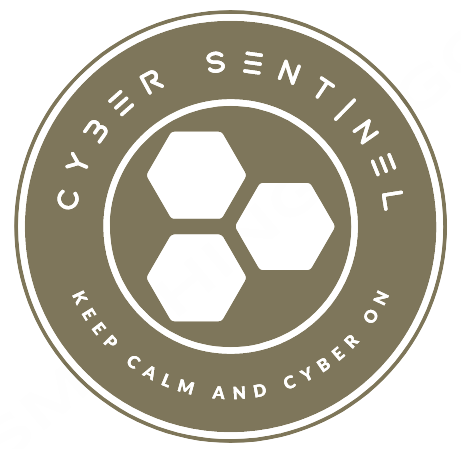




L'ensemble de données UNSW-NB15 est conçu pour servir à la fois à la classification binaire et à la classification multiclasse en matière de détection des intrusions :


>Classification binaire : Dans ce scénario, le modèle prédit si un trafic est normal ou malveillant. C'est le cas le plus courant en détection d'intrusion. Pour cela, la colonne label est utilisée comme cible, où 0 indique un trafic normal et 1 un trafic malveillant.

>Classification multiclasse : Ici, le modèle prédit le type spécifique d'attaque. L'ensemble de données UNSW-NB15 contient plusieurs types d'attaques, et le modèle peut être formé pour prédire quelle catégorie d'attaque spécifique est observée. Dans ce cas, la colonne attack_cat est utilisée comme cible.

1. Exploration des données : Avant de construire un modèle, il est essentiel de comprendre les données. Quelles colonnes le csv contient, combien de données sont disponibles et quelles sont les caractéristiques de ces données.
2. Prétraitement : Il se peut que les données nécessitent une certaine forme de nettoyage, de normalisation ou d'ingénierie des caractéristiques.
3. Construction du modèle : test de plusieurs algorithmes de machine learning adaptés pour construire le modèle de détection d'intrusion. Utiliser un algorithme de classification, comme une forêt aléatoire ou une machine à vecteurs de support, pour prédire la colonne "label".
4. Validation du modèle : Une fois le modèle construit, il est important de le tester pour évaluer ses performances.
5. Déploiement de l'API : Après optimisation et validation, on déploie le modèle sous forme d'API pour une utilisation en temps réel.


## **-- PREPARATION --**

###Imports

In [8]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Création du dataframe

In [10]:
#Création d'un dictionnaire vide
saved_dict = {}

In [11]:
#Lecture des datasets

dfs = []
for i in range(1,5):
    path = '/content/drive/MyDrive/UNSW-NB15_{}.csv'  # 4 csv
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)  # Concaténer en un df

<ipython-input-11-34c53f96292b>:6: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))
<ipython-input-11-34c53f96292b>:6: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(path.format(i), header = None))


In [12]:
#Ajout des noms de colonnes ! Allons les chercher dans NUSW-NB15_features.csv :
df_col = pd.read_csv('/content/drive/MyDrive/NUSW-NB15_features.csv', encoding='ISO-8859-1')


#Harmonisation des noms de colonnes : minuscules partout, retirer les espaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())


#Renommage des noms de colonnes
all_data.columns = df_col['Name']


#Sauvegarde des infos, utiles ultérieurement pour transformer les données brutes des tests.
saved_dict['columns'] = df_col['Name'][df_col['Name']!='label'].tolist()


In [13]:
#Suppression du data frame n'apportant que le header et le descriptif
del df_col

###Affichage

In [ ]:
all_data.shape

all_data.head()


Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

##.Les données contiennent plusieurs colonnes, dont certaines sont des caractéristiques des paquets réseau et d'autres semblent être des métadonnées ou des statistiques dérivées.
Les colonnes comme srcip, dstip, sport, et dsport sont essentielles pour identifier la source et la destination du trafic.
Les colonnes liées à la durée, au débit, à la taille des paquets et aux paquets perdus peuvent fournir des informations sur la qualité et la nature du trafic.
Les colonnes comme state, service, proto et attack_cat peuvent aider à catégoriser le trafic.
Les colonnes comme tcprtt, synack, et ackdat sont importantes pour l'analyse du trafic TCP.
Les colonnes Label et attack_cat sont essentielles pour l'analyse des intrusions et la détection des attaques.

- srcip, dstip: Adresses IP source et destination. Ce sont des informations clés pour identifier d'où proviennent les données et où elles vont.

- sport, dsport: Ports source et destination. Ils sont essentiels pour identifier quel service ou application est utilisé dans une transaction.

- proto: Protocole de transaction. Cette information est utile pour classer le type de trafic.

- state: Indique l'état de la connexion, ce qui peut aider à identifier des comportements anormaux.

- dur: Durée de la connexion. Les connexions très courtes ou très longues peuvent être suspectes.

- sbytes, dbytes: Quantité de données envoyées et reçues. Une grande quantité de données peut indiquer un transfert de données important, comme un téléchargement.

- sttl, dttl: Time to Live des paquets. Des valeurs anormales peuvent indiquer des tentatives de masquage de trafic.

- sloss, dloss: Paquets perdus. Une grande perte de paquets peut indiquer un réseau de mauvaise qualité ou des attaques.

- service: Type de service utilisé. Certains services sont plus souvent ciblés par des attaques.

- Sload, Dload: Débit du réseau. Un débit anormalement élevé ou faible peut être suspect.

- Spkts, Dpkts: Nombre de paquets envoyés et reçus.

- swin, dwin: Valeurs de la fenêtre TCP. Des valeurs anormales peuvent indiquer des tentatives d'attaque.

- stcpb, dtcpb: Numéros de séquence TCP. Ils sont importants pour l'analyse du trafic TCP.

- smeansz, dmeansz: Taille moyenne des paquets.

- trans_depth: Profondeur de la transaction HTTP.

- res_bdy_len: Taille du contenu HTTP.

- Sjit, Djit: Jitter source et destination. Le jitter peut indiquer des problèmes de réseau.

- Stime, Ltime: Temps de début et de fin de l'enregistrement.

- Sintpkt, Dintpkt: Temps entre paquets.

- tcprtt, synack, ackdat: Temps de configuration de la connexion TCP.

- is_sm_ips_ports: Indique si l'adresse IP source et destination ainsi que les ports sont identiques.

- ct_state_ttl, ct_flw_http_mthd, is_ftp_login, ct_ftp_cmd, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm: Ces colonnes fournissent des informations sur le comportement et les motifs des connexions.

- attack_cat: Catégorie d'attaque. C'est une information essentielle pour classer et identifier le type d'attaque.

- Label: Étiquette indiquant si c'est une attaque ou non.

->     Les deux colonnes les plus importantes pour nous sont :
       attack_cat : Catégorie de l'attaque.
       label : Indicateur binaire de si l'entrée est malveillante (0 pour normal, 1 pour malveillant).

### Enregistrer le dataset agrégé

In [ ]:
#all_data.to_csv('all_data.csv', index=False)

## **-- NETTOYAGE --**

### Imports supplémentaires (visualisations, machine learning...)

In [15]:
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict


### J'instaurerai plus tard que prévu train et test. Mais je renomme le DF pour ne pas modifier chaque ligne de code écrit précédemment !

In [16]:
train = all_data

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

###.
1.   Vérifier s'il y a des valeurs manquantes.
2.   Vérifier la présence de valeurs aberrantes ou suspectes.
3.   Examiner la distribution des types de données.
4.   Examiner les valeurs uniques pour les colonnes catégorielles et convertir les caractéristiques catégorielles en numériques (par exemple, "proto", "state").
5.   Normaliser les caractéristiques numériques.




### Test : Données redondantes - Ne pas activer

Je retire tout ce code, car les résultats suivants sont faussés ! Cette quantité d'activités redondantes correspondent à un total normal et les amoindrir biaisent les résultats ! Par ex, nombre de colonnes corrélées avec la totalité des lignes : 18 VS 8 lorsque l'on retire les doublons. 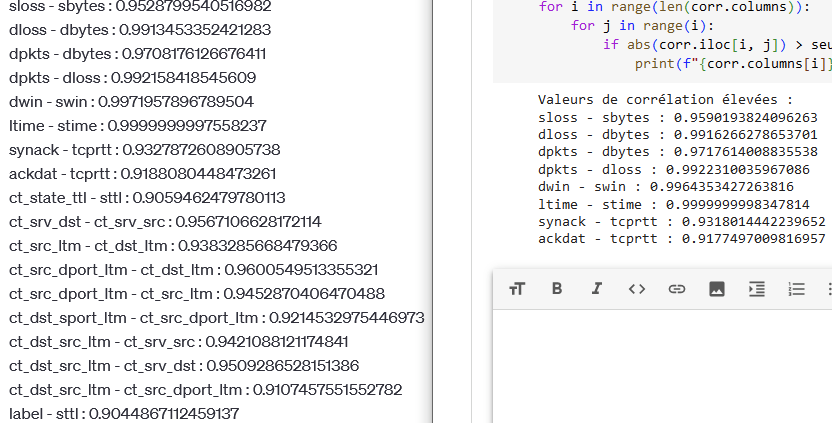

In [ ]:
doublons = train.duplicated()

# Afficher les lignes en double
print(train[doublons])

# Compter le nombre total de lignes en double
nb_doublons = train.duplicated().sum()
print(f"Nombre total de lignes en double : {nb_doublons}")

Name            srcip  sport           dstip dsport proto state        dur  \
11        10.40.170.2      0     10.40.170.2      0   arp   INT   0.000000   
12        10.40.182.3      0     10.40.182.3      0   arp   INT   0.000000   
72         59.166.0.6  15807   149.171.126.7     53   udp   CON   0.001118   
121       10.40.182.1      0       224.0.0.5      0  ospf   INT  50.004337   
122        10.40.85.1      0       224.0.0.5      0  ospf   INT  50.004341   
...               ...    ...             ...    ...   ...   ...        ...   
2540027  175.45.176.0  47439  149.171.126.10     53   udp   INT   0.000001   
2540035    59.166.0.5  53521   149.171.126.7     21   tcp   CON   1.086072   
2540040    59.166.0.9  61886   149.171.126.1     21   tcp   CON   3.108071   
2540043    59.166.0.7  20848   149.171.126.4     21   tcp   CON   0.365058   
2540044    59.166.0.3  21511   149.171.126.9     21   tcp   CON   6.335154   

Name     sbytes  dbytes  sttl  ...  ct_ftp_cmd  ct_srv_src  ct_

In [ ]:
# Identifiez les indices des lignes en double
index_doublons = train.duplicated().index[train.duplicated()].tolist()

# Obtenez les valeurs UNIQUE de la colonne 'label' pour ces indices
valeurs_label_doublons = train.loc[index_doublons, 'label'].unique()


# Affichez les valeurs de la colonne 'label' des lignes redondantes
print(valeurs_label_doublons)

[0 1]


In [ ]:
#Suppression des lignes dupliquées
#train = train.drop_duplicates()

In [ ]:
#train.to_csv('train.csv', index=False)

### Valeurs nulles, manquantes

In [17]:
#Vérification des valeurs nulles
train.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

Les "Pas d'attaque" (NaN) sont renommées en "normal" et on retire le "s" qui apparaît après certains "backdoors".

In [18]:
train['attack_cat'].value_counts()

Generic             215481
Exploits             44525
 Fuzzers             19195
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Backdoors              534
Shellcode              223
Worms                  174
Name: attack_cat, dtype: int64

In [19]:
train['attack_cat'] = train.attack_cat.fillna(value="normal").apply(lambda x: x.strip().lower())
train['attack_cat'] = train.attack_cat.replace("backdoors", "backdoor")
train['attack_cat'].value_counts()

#unique_values = train['attack_cat'].unique()
#print(unique_values)

normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             2329
shellcode            1511
worms                 174
Name: attack_cat, dtype: int64

Remplissage de valeurs nulles (NaN) dans les colonnes "ct_flw_http_mthd" et "is_ftp_login" par "0"

In [20]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value=0)

train['is_ftp_login'] = (train.is_ftp_login.fillna(value=0)).astype(int)

In [21]:
#Résultat ?
train.isnull().sum().sum()

0

### Valeurs aberrantes ou suspectes

In [22]:
# Display descriptive statistics for numerical columns
numerical_stats = train.describe()

numerical_stats

Name,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,...,ct_flw_http_mthd,is_ftp_login,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,label
count,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,...,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06,2.540047e+06
mean,6.587916e-01,4.339600e+03,3.642759e+04,6.278197e+01,3.076681e+01,5.163921e+00,1.632944e+01,3.695645e+07,2.450861e+06,3.328884e+01,...,1.100779e-01,1.735125e-02,9.206988e+00,8.988958e+00,6.439103e+00,6.900986e+00,4.642139e+00,3.592729e+00,6.845886e+00,1.264870e-01
std,1.392493e+01,5.640599e+04,1.610960e+05,7.462277e+01,4.285089e+01,2.251707e+01,5.659474e+01,1.186043e+08,4.224863e+06,7.628388e+01,...,5.564195e-01,1.334571e-01,1.083676e+01,1.082249e+01,8.162034e+00,8.205062e+00,8.477579e+00,6.174445e+00,1.125828e+01,3.323975e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.037000e-03,2.000000e+02,1.780000e+02,3.100000e+01,2.900000e+01,0.000000e+00,0.000000e+00,1.353963e+05,1.191594e+04,2.000000e+00,...,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.586100e-02,1.470000e+03,1.820000e+03,3.100000e+01,2.900000e+01,3.000000e+00,4.000000e+00,5.893038e+05,5.893179e+05,1.200000e+01,...,0.000000e+00,0.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00
75%,2.145545e-01,3.182000e+03,1.489400e+04,3.100000e+01,2.900000e+01,7.000000e+00,1.400000e+01,2.039923e+06,2.925974e+06,4.400000e+01,...,0.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01,6.000000e+00,7.000000e+00,2.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00
max,8.786638e+03,1.435577e+07,1.465753e+07,2.550000e+02,2.540000e+02,5.319000e+03,5.507000e+03,5.988000e+09,1.287619e+08,1.064600e+04,...,3.600000e+01,4.000000e+00,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.000000e+01,6.700000e+01,1.000000e+00


Les statistiques descriptives nous fournissent des informations utiles sur la distribution des données pour chaque colonne numérique. Voici quelques points à noter:

Certaines colonnes ont des valeurs minimales ou maximales qui peuvent être considérées comme extrêmes par rapport à la distribution générale. Par exemple, pour la colonne dbytes, le maximum est beaucoup plus élevé que le 75e percentile.

Certaines colonnes ont une distribution très concentrée autour de valeurs spécifiques. Par exemple, les colonnes sttl, dttl, et plusieurs autres ont une médiane et un mode qui sont les mêmes ou très proches.

### Distribution des types de données

In [23]:
data_types_distribution = train.dtypes.value_counts()

data_types_distribution

int64      29
float64    11
object      9
dtype: int64

Vérifications des colonnes binaires :

In [24]:
# Check unique values in the 'is_sm_ips_ports' column
unique_values_is_sm_ips_ports = train['is_sm_ips_ports'].unique()

unique_values_is_sm_ips_ports

array([0, 1])

In [25]:
# Check unique values in the 'label' column
unique_values_label = train['label'].unique()

unique_values_label

array([0, 1])

Le bug est ici : 4 valeurs au lieu de 2

In [26]:
# Check unique values in the 'is_ftp_login' column
unique_values_is_ftp_login = train['is_ftp_login'].unique()

unique_values_is_ftp_login

array([0, 1, 2, 4])

In [27]:
filtered_rows = train[train['is_ftp_login'].isin([2, 4])]
filtered_rows

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
1103952,59.166.0.5,63062,149.171.126.2,21,tcp,FIN,1.459935,1786,2340,31,...,2,2,2,3,5,2,2,4,normal,0
1103957,59.166.0.5,63062,149.171.126.2,21,tcp,FIN,1.459935,1786,2340,31,...,2,2,2,3,5,2,2,4,normal,0
1134251,59.166.0.5,64596,149.171.126.1,21,tcp,FIN,0.754596,2934,3742,31,...,4,2,2,9,8,2,2,7,normal,0
1134270,59.166.0.5,64596,149.171.126.1,21,tcp,FIN,0.754596,2934,3742,31,...,4,2,2,9,8,2,2,7,normal,0
1141399,59.166.0.5,18379,149.171.126.4,21,tcp,FIN,0.021492,2934,3742,31,...,4,2,2,6,8,2,2,7,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540034,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,...,2,2,2,2,2,2,2,2,normal,0
2540035,59.166.0.5,53521,149.171.126.7,21,tcp,CON,1.086072,1940,2404,31,...,2,2,2,3,3,2,2,3,normal,0
2540040,59.166.0.9,61886,149.171.126.1,21,tcp,CON,3.108071,1148,1402,31,...,2,2,2,2,4,2,2,3,normal,0
2540043,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,...,2,2,2,2,2,2,2,2,normal,0


In [28]:
filtered_rows = train[(train['is_ftp_login'].isin([2, 4])) & (train['label'] == 1)]
filtered_rows

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
1164440,175.45.176.1,52941,149.171.126.10,21,tcp,FIN,55.968578,1560,1364,254,...,2,4,4,1,2,1,1,4,fuzzers,1
1164448,175.45.176.1,52941,149.171.126.10,21,tcp,FIN,55.968578,1560,1364,254,...,2,3,3,1,1,1,1,3,fuzzers,1
1164832,175.45.176.1,52899,149.171.126.10,21,tcp,FIN,34.455128,1610,1364,254,...,2,4,4,2,2,2,2,4,fuzzers,1
1164833,175.45.176.1,52899,149.171.126.10,21,tcp,FIN,34.455128,1610,1364,254,...,2,4,4,2,2,2,2,4,fuzzers,1
1259409,175.45.176.3,50068,149.171.126.13,21,tcp,FIN,0.448151,602,690,62,...,2,2,2,4,4,2,2,4,exploits,1
1259411,175.45.176.3,50068,149.171.126.13,21,tcp,FIN,0.448151,602,690,62,...,2,2,2,4,4,2,2,4,exploits,1
1259414,175.45.176.3,50068,149.171.126.13,21,tcp,FIN,0.448151,602,690,62,...,2,2,2,4,4,2,2,4,exploits,1
1259415,175.45.176.3,50068,149.171.126.13,21,tcp,FIN,0.448151,602,690,62,...,2,2,2,4,4,2,2,4,exploits,1
1871281,175.45.176.1,56910,149.171.126.16,21,tcp,CON,1.564220,690,940,62,...,4,2,2,2,5,2,2,2,exploits,1
1871300,175.45.176.1,56910,149.171.126.16,21,tcp,CON,1.564220,690,940,62,...,4,2,2,2,5,2,2,2,exploits,1


In [29]:
#column_data = filtered_rows['is_ftp_login']


Toutes ces entrées sont associées au port 21, qui est le port FTP standard.
La colonne attack_cat indique "normal" et "activités malveillantes".

Peut-être que 2 et 4 sont des codes pour des types spécifiques de sessions FTP ou de commandes FTP (par exemple, 2 pourrait signifier une tentative d'authentification FTP échouée et 4 pourrait signifier une tentative d'authentification FTP réussie avec des commandes malveillantes : pas seulement)? Si ces valeurs ont une signification pertinente pour l'analyse ou le modèle, on peut choisir de les conserver et de traiter la colonne comme une variable catégorielle.

Si elles n'ont pas de signification ou si elles perturbent l'analyse, on les traite comme port FTP standard = 1.

Analyse supplémentaire : Examiner d'autres caractéristiques de ces lignes pour voir si elles présentent des schémas particuliers. Par exemple, y a-t-il d'autres colonnes qui ont des valeurs inhabituelles pour ces lignes ?

### Valeurs uniques pour les colonnes catégorielles

Pour comprendre les données et pour la préparation des données pour le machine learning.

In [30]:
# Check unique values for categorical columns
categorical_columns = train.select_dtypes(include=['object']).columns
unique_values_categorical = {col: train[col].unique() for col in categorical_columns}

unique_values_categorical

{'srcip': array(['59.166.0.0', '59.166.0.6', '59.166.0.5', '59.166.0.3',
        '10.40.182.3', '59.166.0.7', '10.40.170.2', '59.166.0.1',
        '59.166.0.2', '59.166.0.4', '175.45.176.3', '175.45.176.2',
        '175.45.176.0', '59.166.0.8', '59.166.0.9', '175.45.176.1',
        '10.40.182.1', '10.40.85.1', '192.168.241.243', '10.40.85.30',
        '149.171.126.16', '149.171.126.2', '149.171.126.11',
        '149.171.126.4', '149.171.126.5', '149.171.126.17',
        '149.171.126.19', '149.171.126.9', '149.171.126.8',
        '149.171.126.7', '149.171.126.15', '149.171.126.6',
        '149.171.126.0', '149.171.126.1', '149.171.126.3',
        '149.171.126.13', '149.171.126.12', '149.171.126.10',
        '149.171.126.18', '127.0.0.1', '149.171.126.14', '10.40.85.10',
        '10.40.182.6'], dtype=object),
 'sport': array([1390, 33661, 1464, ..., 533, 933, 706], dtype=object),
 'dstip': array(['149.171.126.6', '149.171.126.9', '149.171.126.7', '149.171.126.5',
        '149.171.126.0',

srcip et dstip : Ces colonnes contiennent des adresses IP. Elles semblent propres et sans valeurs aberrantes à première vue.

proto : Cette colonne contient différents protocoles de communication. Les valeurs semblent appropriées. La plupart du trafic utilise les protocoles tcp et udp, qui sont les protocoles les plus courants pour le trafic Internet. Il y a 65 protocoles uniques dans cet ensemble de données, mais beaucoup d'entre eux ont un faible nombre d'occurrences.

state (état de connexion): Les valeurs dans cette colonne indiquent l'état de la connexion. Les valeurs semblent également appropriées. La majorité des connexions sont dans l'état FIN (terminé) ou CON (établi).

service : Cette colonne identifie le service utilisé (par exemple, HTTP, DNS). Il y a une valeur '-' qui pourrait représenter des données manquantes ou inconnues.

ct_ftp_cmd : Cette colonne semble contenir des valeurs numériques, bien qu'elle soit traitée comme catégorielle. Il serait judicieux de vérifier si elle devrait être convertie en type numérique.

attack_cat : Cette colonne identifie la catégorie d'attaque. Les valeurs semblent appropriées.



## Conversion en Parquet
Suite aux rapports d'erreur lors de création de .parquet

In [31]:
non_numeric_values = train['sport'][~train['sport'].astype(str).str.isnumeric()].unique()
print(non_numeric_values)

['0x000b' '0x000c' '-']


In [32]:
# Convert the problematic values in 'sport' column to int64
def convert_to_int64_v2(value):
    # Check if the value is already an integer
    if isinstance(value, int):
        return value
    # Convert hexadecimal values to int
    elif value.startswith('0x'):
        return int(value, 16)
    # Convert '-' to a default value (e.g., -1)
    elif value == '-':
        return -1
    # Convert other string values directly to int
    else:
        return int(value)

train['sport'] = train['sport'].apply(convert_to_int64_v2)

# Check the data type and unique non-numeric values again
data_type_sport = train['sport'].dtype
unique_values_sport = train['sport'].unique()

data_type_sport, unique_values_sport

(dtype('int64'), array([ 1390, 33661,  1464, ...,   533,   933,   706]))

In [33]:
# Check unique values in the 'dsport' column to identify problematic values
unique_values_dsport = train['dsport'].unique()

unique_values_dsport

array(['53', '1024', '111', ..., '41921', '24470', '30870'], dtype=object)

In [34]:
def convert_dsport_to_int_updated(value):
    # Check if the value is already an integer or a numeric string
    if isinstance(value, int) or str(value).isnumeric():
        return int(value)
    # Convert hexadecimal values to int
    elif value.startswith('0x'):
        return int(value, 16)
    # Convert '-' to a default value (e.g., -1)
    elif value == '-':
        return -1
    # Convert other string values directly to int (this might not be necessary, but is kept for completeness)
    else:
        return int(value)

# Apply the updated conversion function to the 'dsport' column
train['dsport'] = train['dsport'].apply(convert_dsport_to_int_updated)

# Check the data type and unique non-numeric values again for 'dsport'
data_type_dsport = train['dsport'].dtype
unique_non_numeric_values_dsport_updated = train['dsport'][~train['dsport'].astype(str).str.isnumeric()].unique()

data_type_dsport, unique_non_numeric_values_dsport_updated

(dtype('int64'), array([-1]))

In [35]:
# Check unique values in the 'ct_ftp_cmd' column
unique_values_ct_ftp_cmd = train['ct_ftp_cmd'].unique()

unique_values_ct_ftp_cmd

array([0, 1, 6, 2, 4, 8, 5, 3, '0', '1', ' ', '2', '4'], dtype=object)

In [36]:
def convert_ct_ftp_cmd_updated(value):
    # Check if the value is already an integer
    if isinstance(value, int):
        return value
    # Convert numeric strings to integers
    elif value.strip().isnumeric():
        return int(value)
    # Convert space to a default value (e.g., -1)
    elif value.strip() == '':
        return -1
    # Handle other values (this might not be necessary, but is kept for completeness)
    else:
        return value

# Apply the updated conversion function to the 'ct_ftp_cmd' column in the sample data
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].apply(convert_ct_ftp_cmd_updated)

# Check the data type and unique values again for 'ct_ftp_cmd'
data_type_ct_ftp_cmd_updated = train['ct_ftp_cmd'].dtype
unique_values_ct_ftp_cmd_updated = train['ct_ftp_cmd'].unique()

data_type_ct_ftp_cmd_updated, unique_values_ct_ftp_cmd_updated

(dtype('int64'), array([ 0,  1,  6,  2,  4,  8,  5,  3, -1]))

Enregistrement en .parquet

In [37]:
'''import pyarrow as pa
import pyarrow.parquet as pq

table = pa.Table.from_pandas(train)
petittrain = "/content/drive/My Drive/petittrain.parquet"
pq.write_table(table, petittrain)'''

'import pyarrow as pa\nimport pyarrow.parquet as pq\n\ntable = pa.Table.from_pandas(train)\npetittrain = "/content/drive/My Drive/petittrain.parquet"\npq.write_table(table, petittrain)'

## Ras le bol du DF trop lourd pour les calculs - Ne pas cliquer


In [ ]:
# Extraire un échantillon aléatoire de 1000 lignes
sample_train = train.sample(n=1000)

# Count the occurrences of each label in the 'label' column
label_counts = sample_train['label'].value_counts()

# Calculate the percentage for each label
label_percentages = (label_counts / len(sample_train)) * 100

label_percentages

# Enregistrer l'échantillon dans un fichier CSV
sample_train.to_csv("/content/drive/MyDrive/sample_train.csv", index=False)

## -- VISUALISATION --

### PREMIERES VISUALISATIONS - NE PAS CLIQUER car trop de calculs

Votre session a planté après avoir utilisé toute la mémoire RAM disponible. Si vous êtes intéressé par un accès à des environnements d'exécution à mémoire RAM élevée, nous vous conseillons la version Pro.

[<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>]

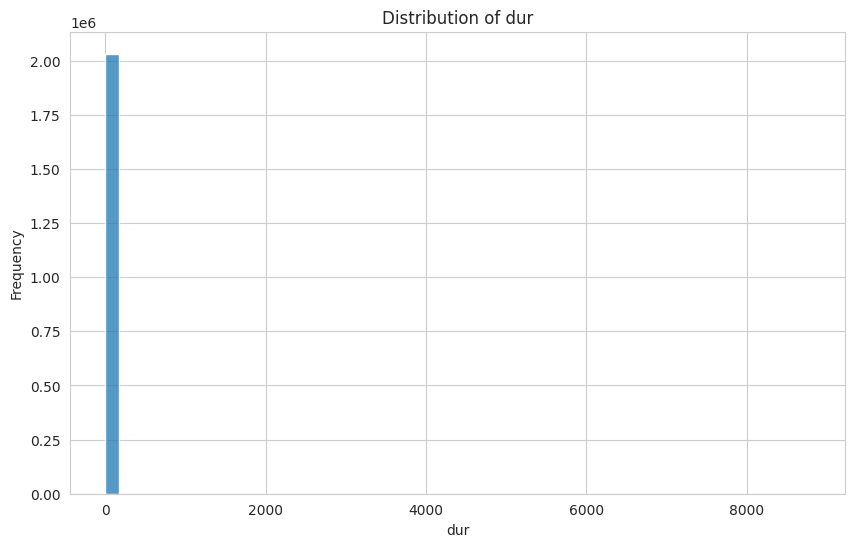

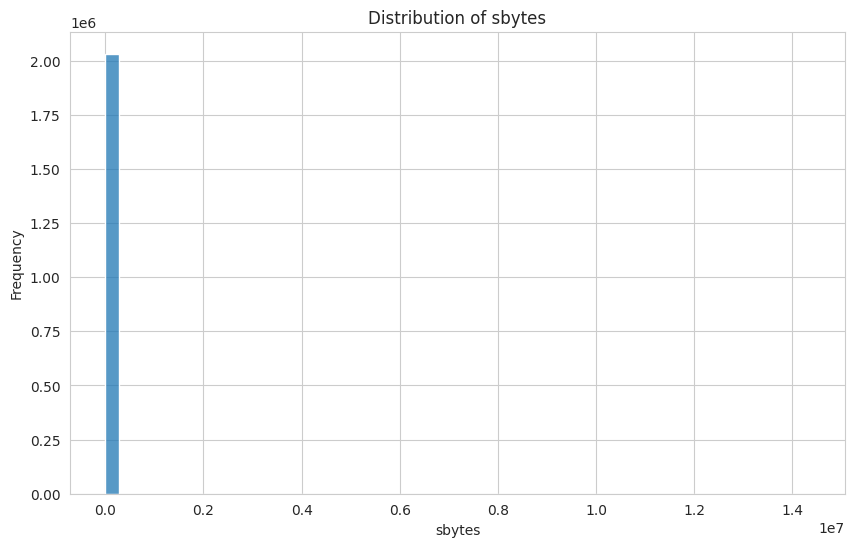

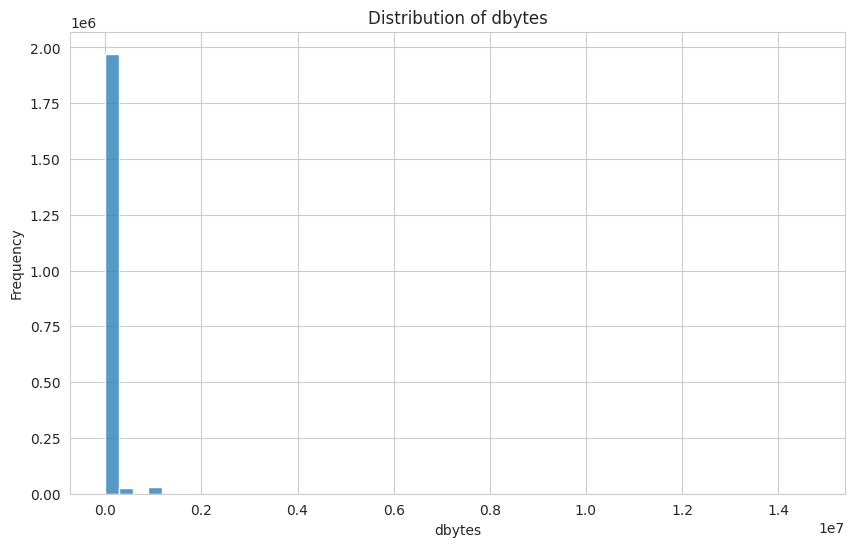

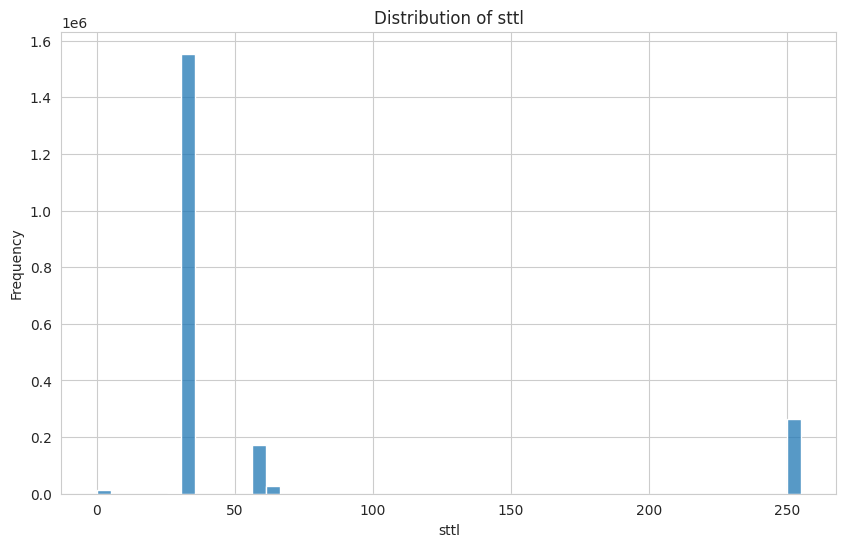

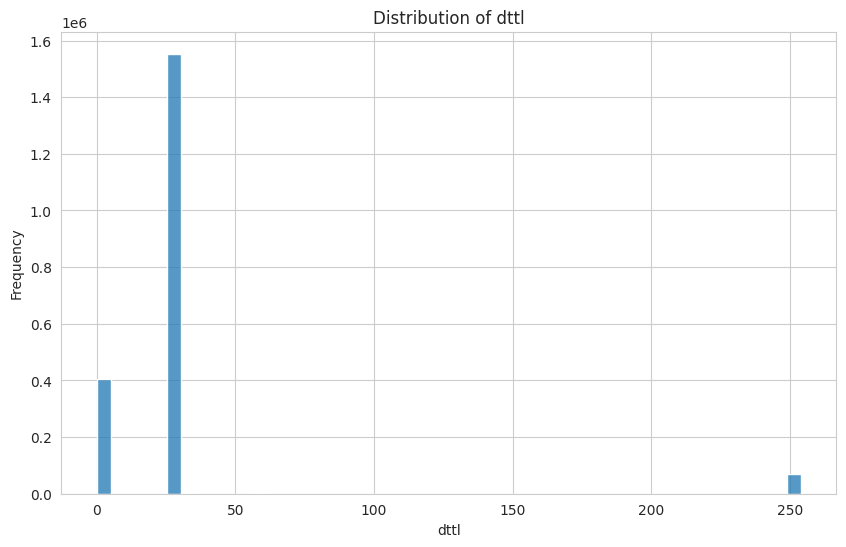

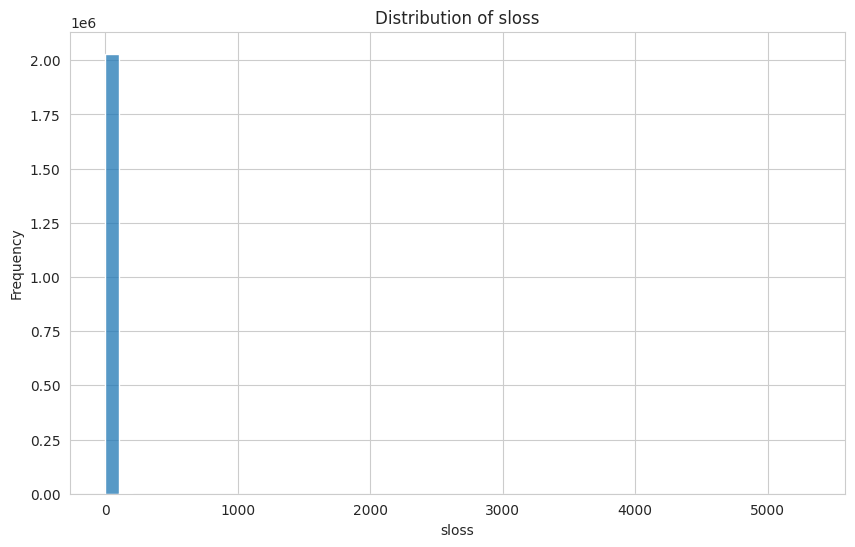

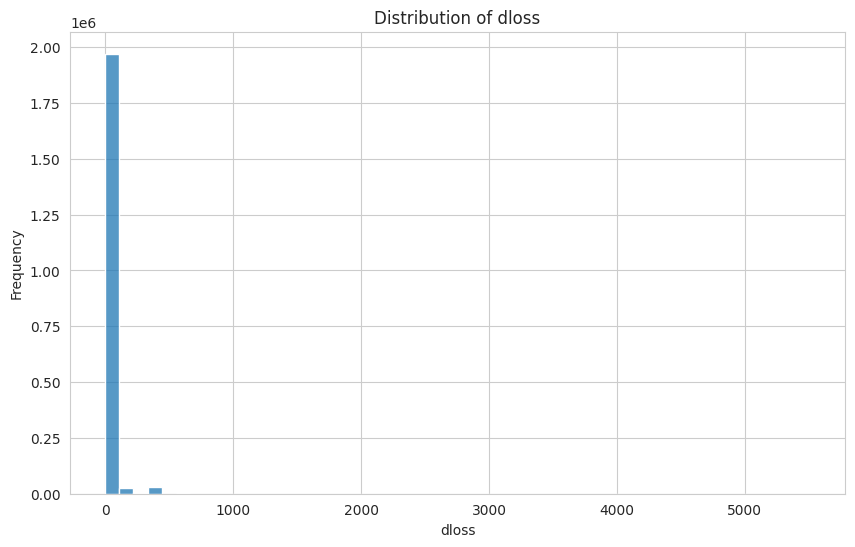

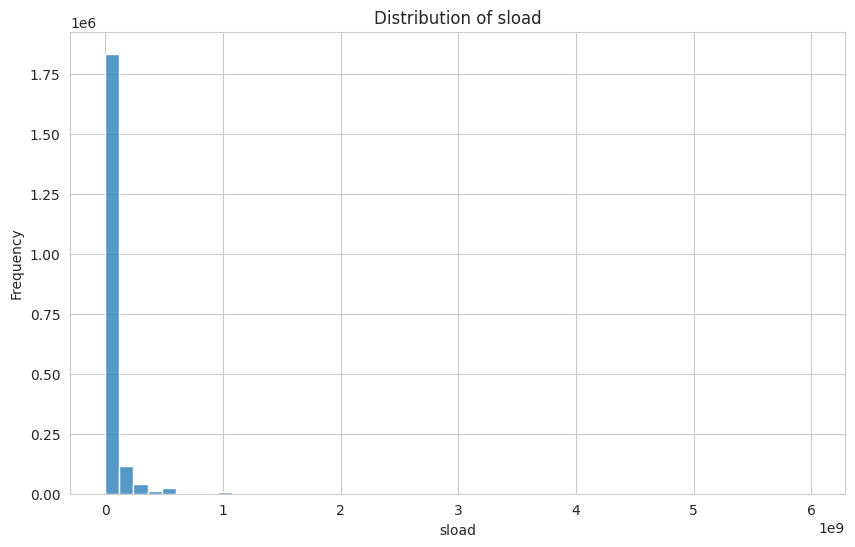

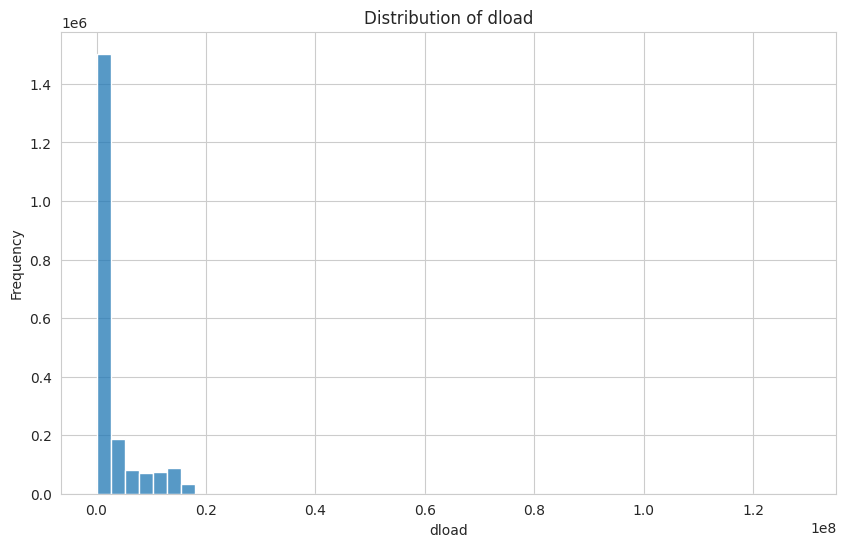

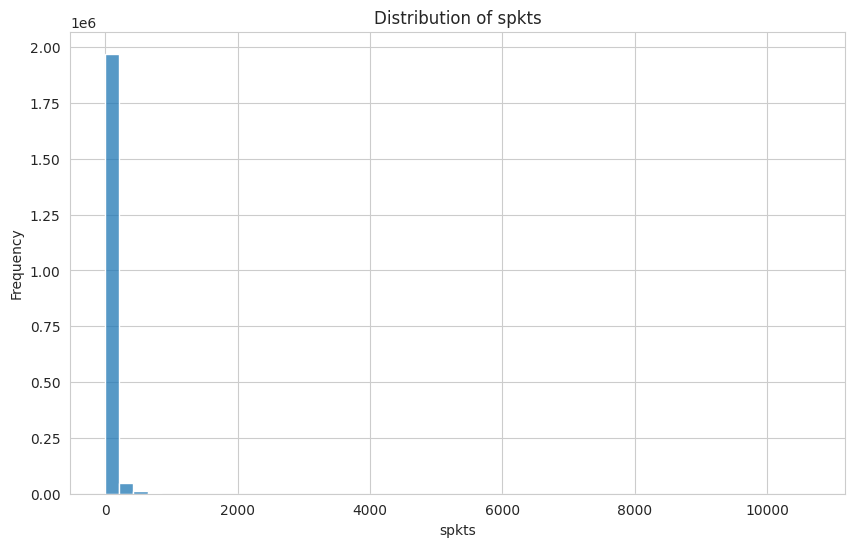

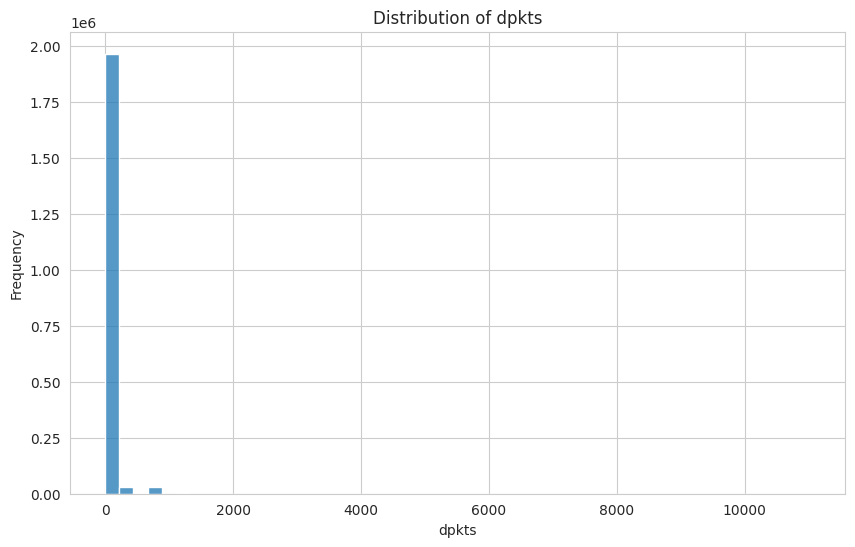

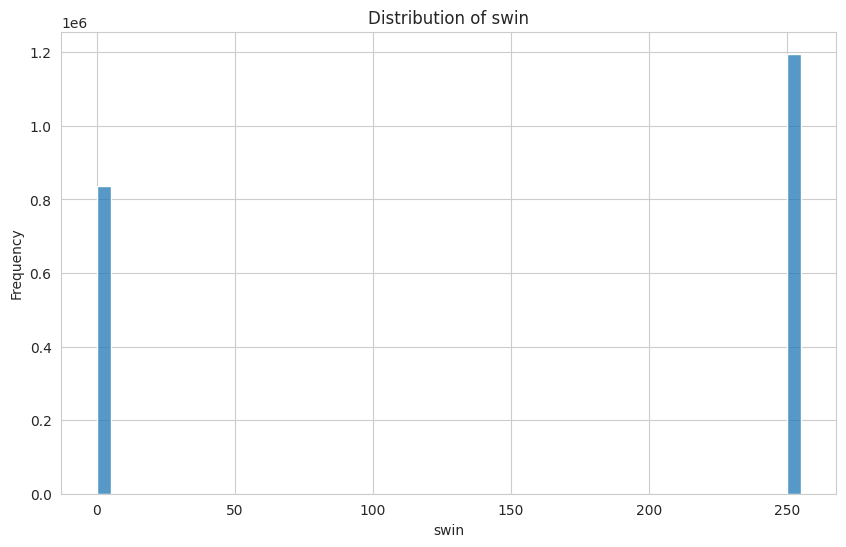

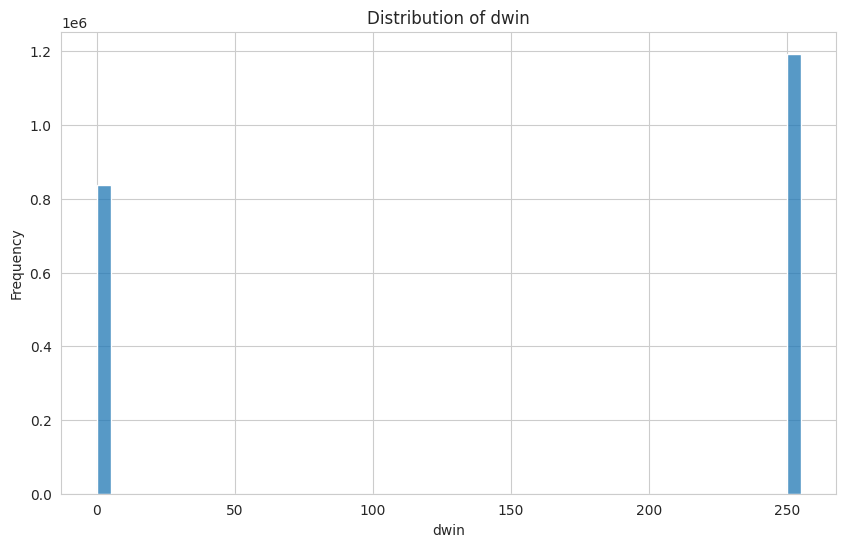

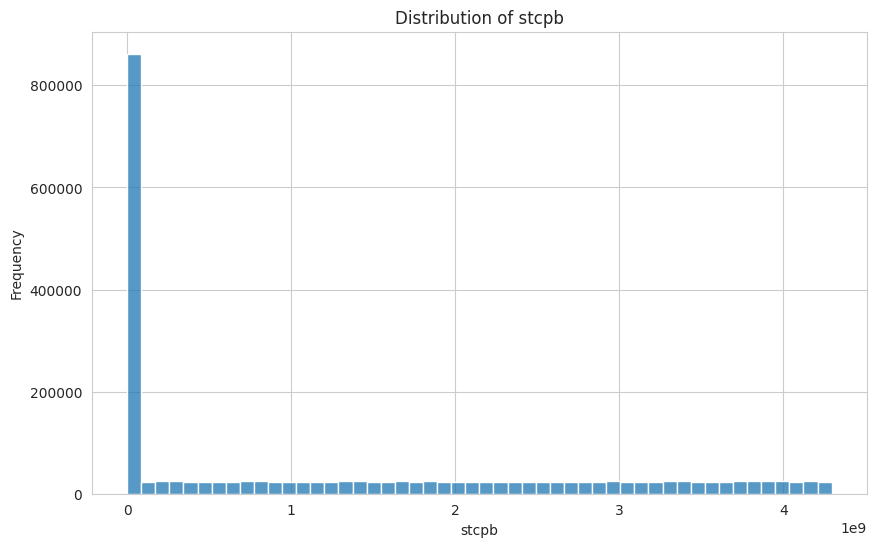

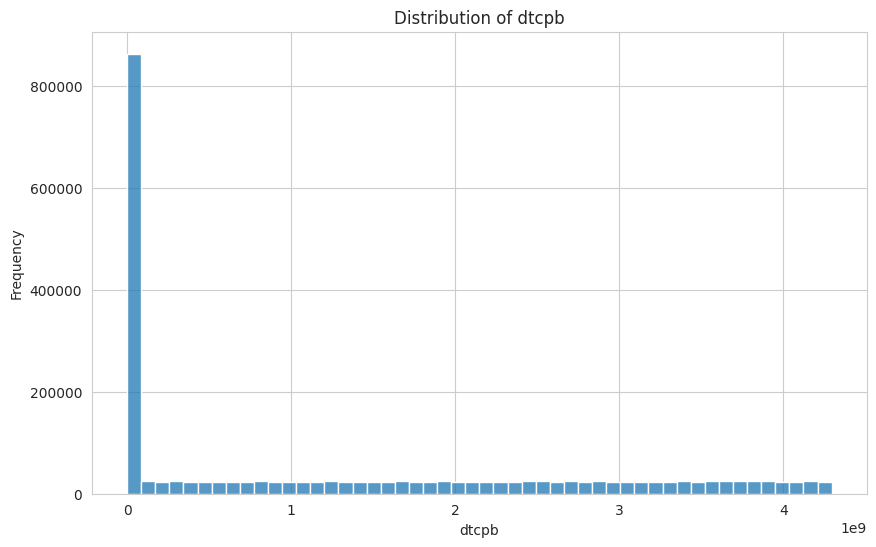

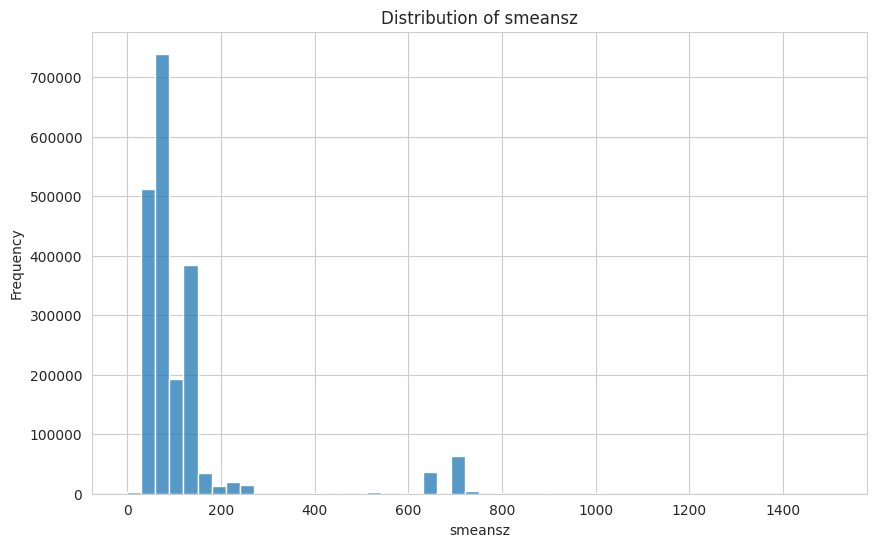

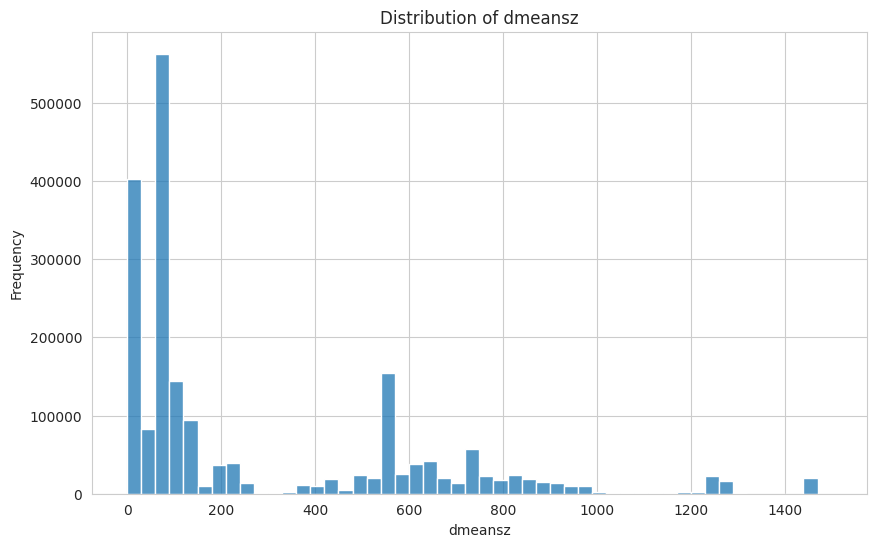

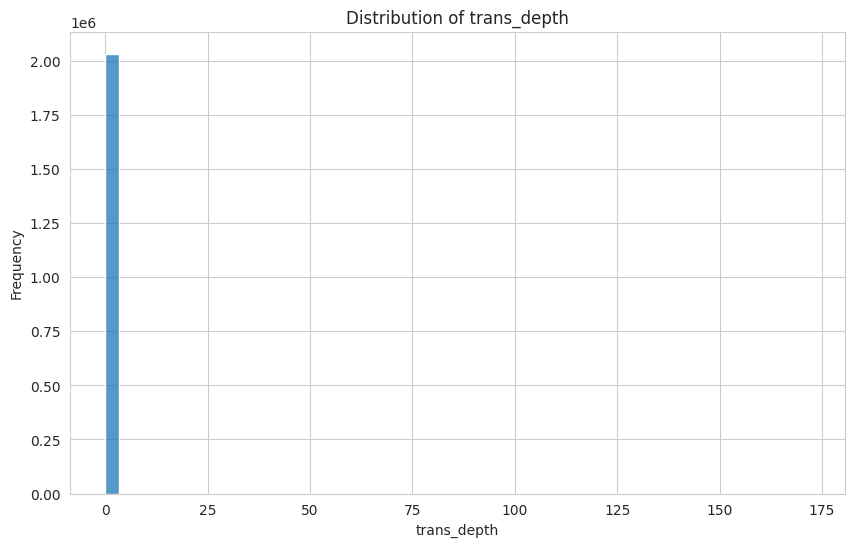

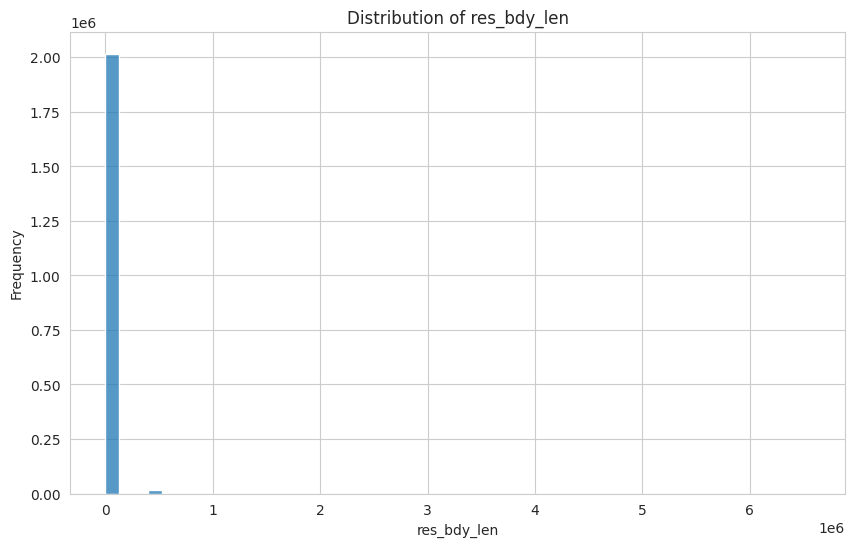

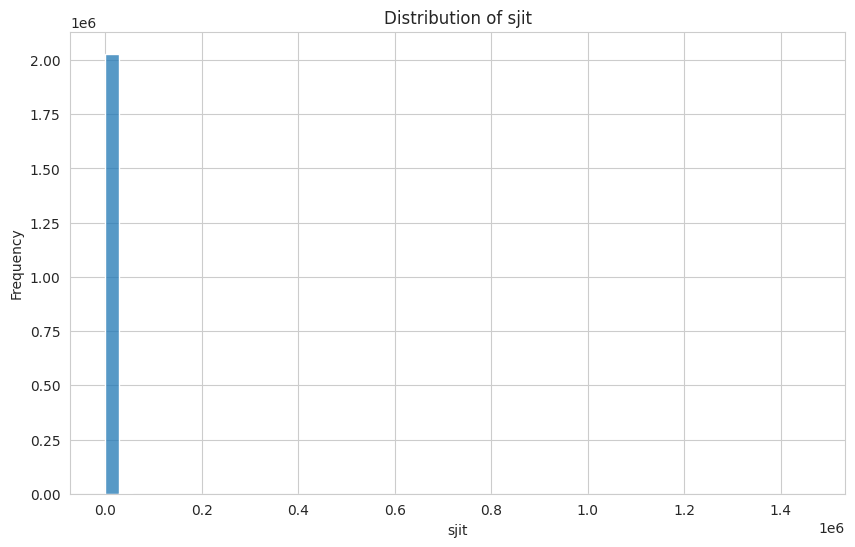

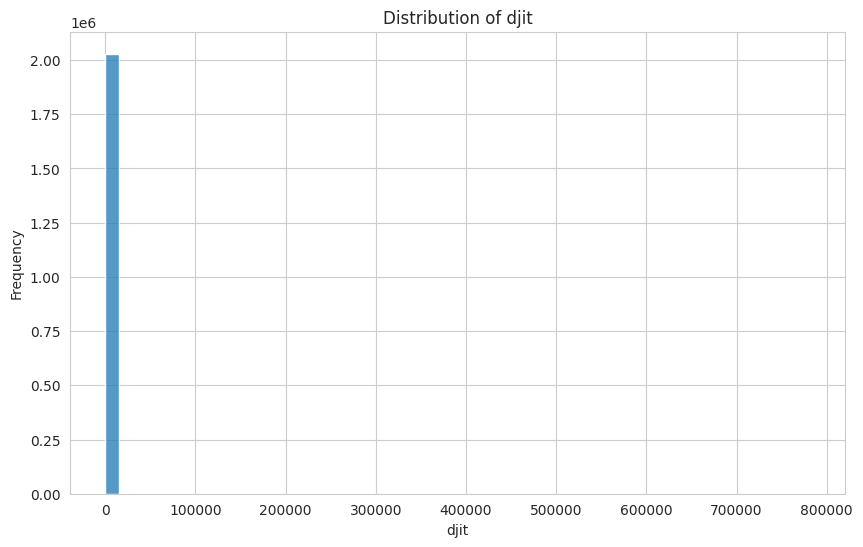

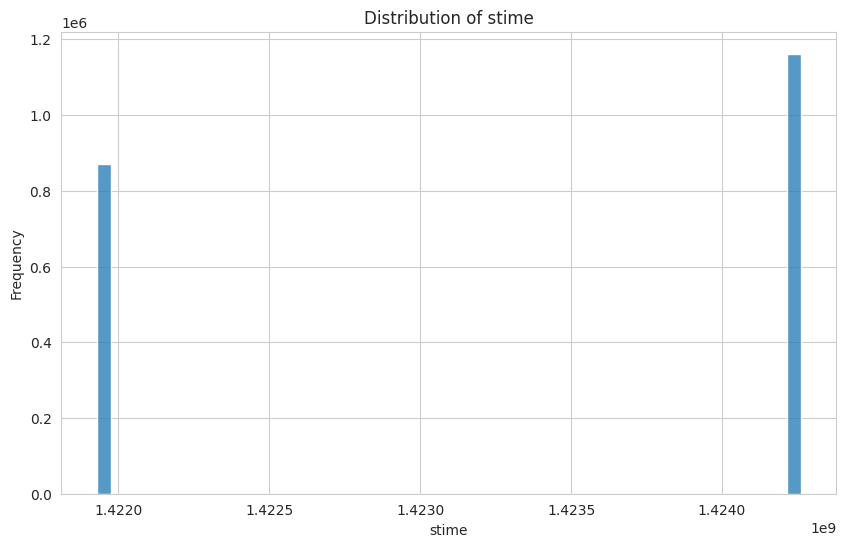

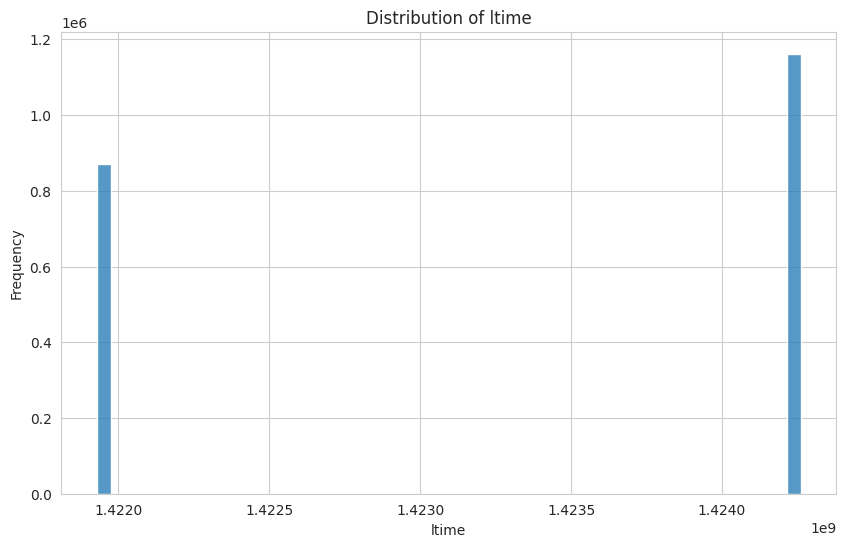

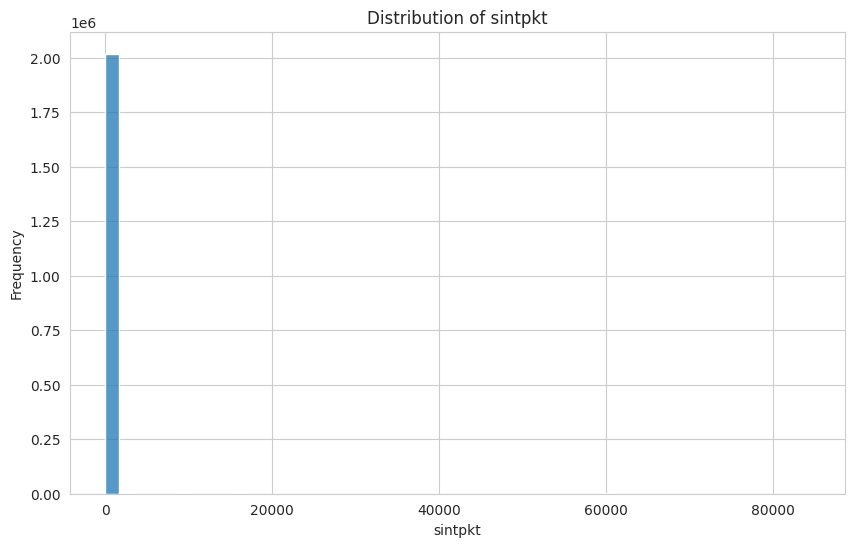

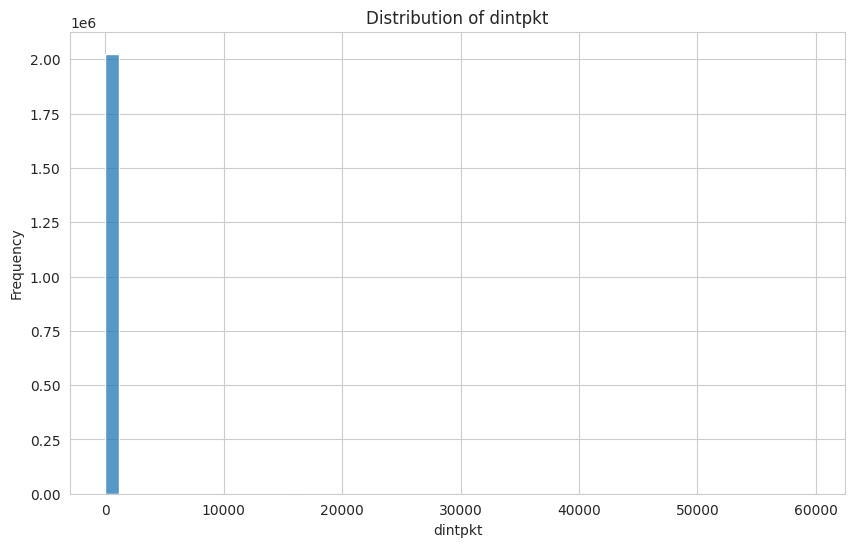

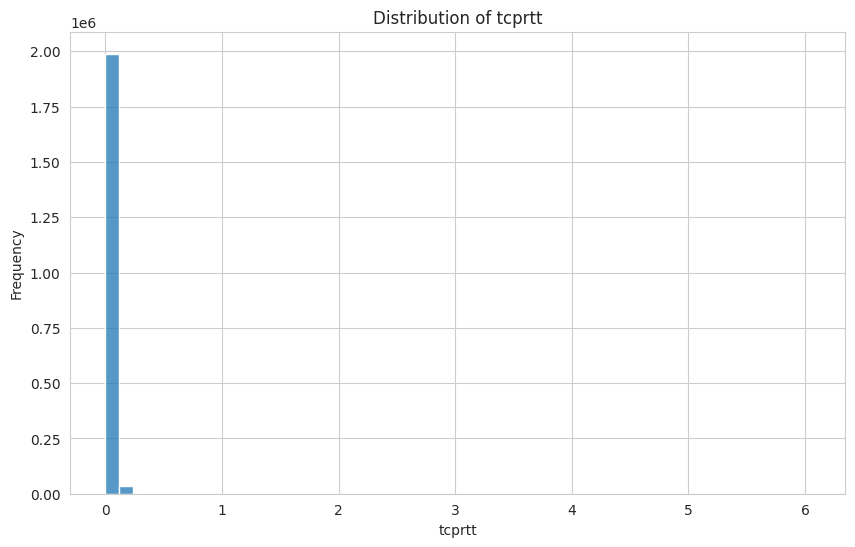

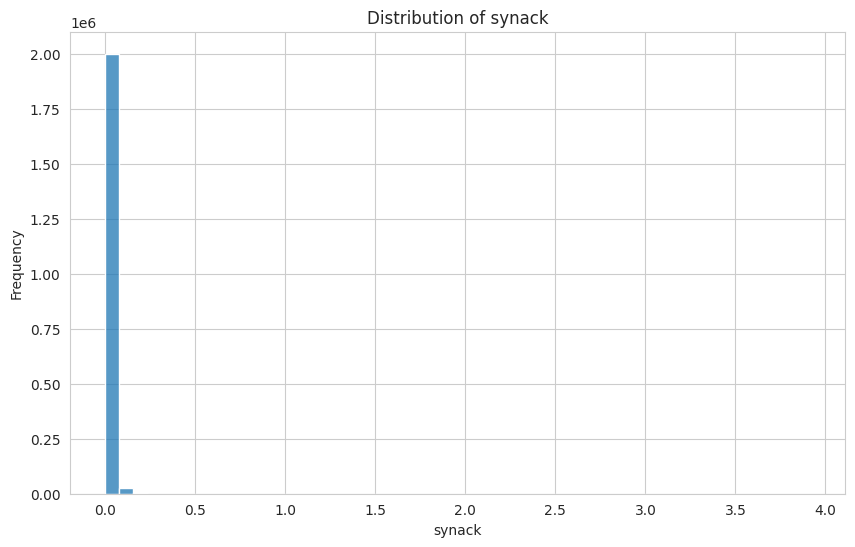

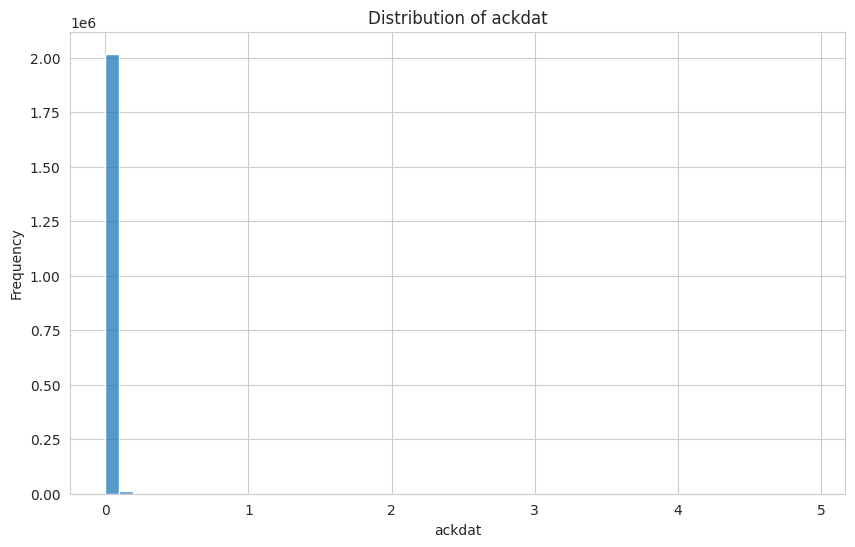

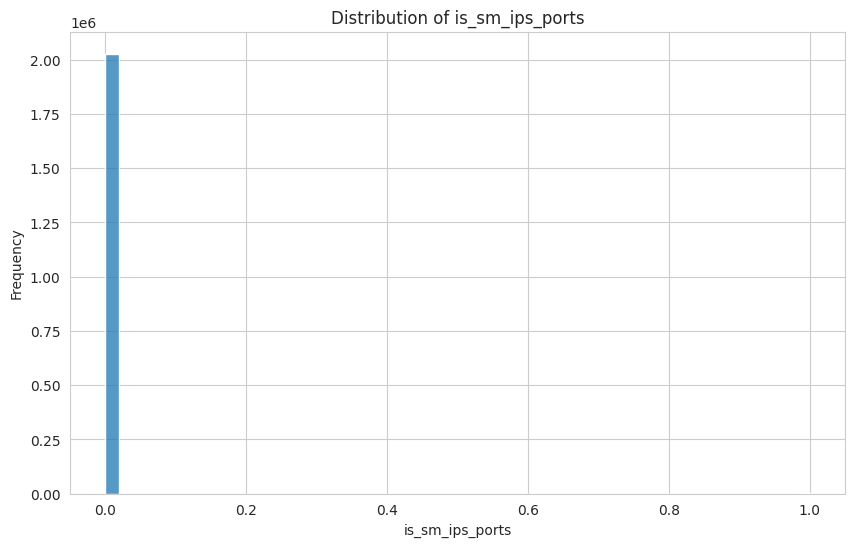

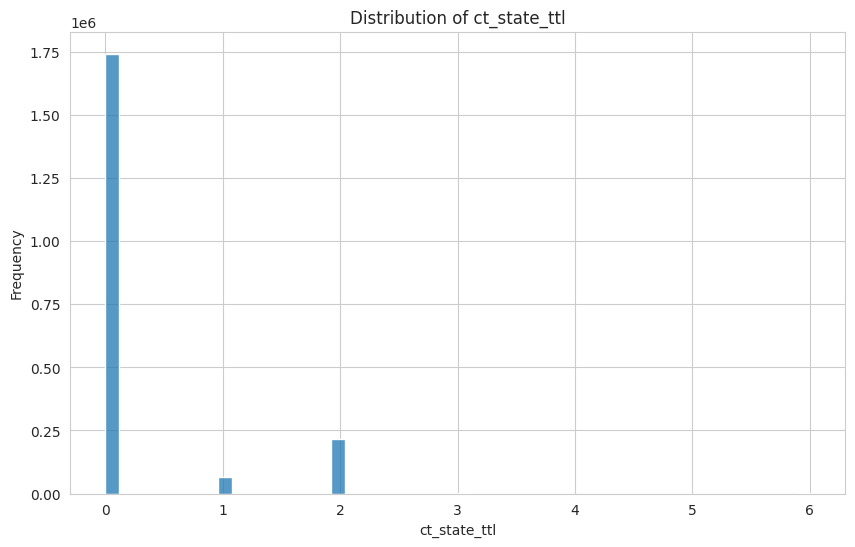

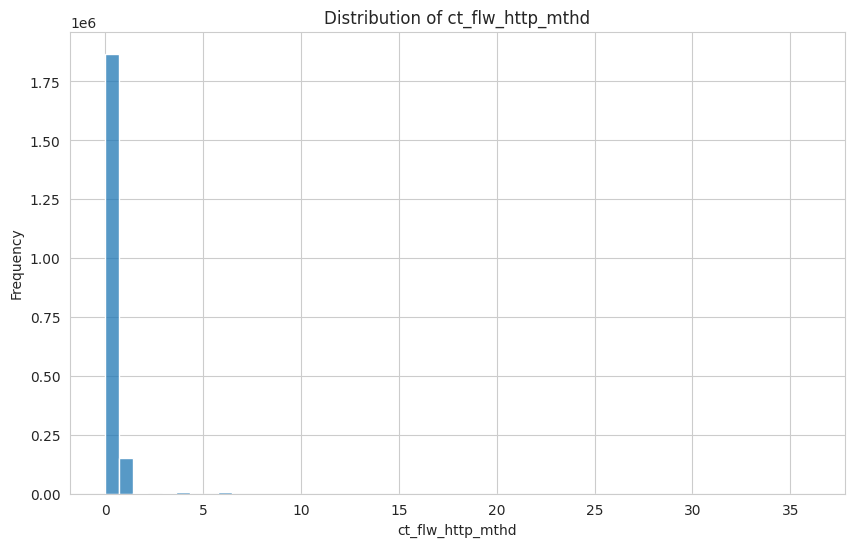

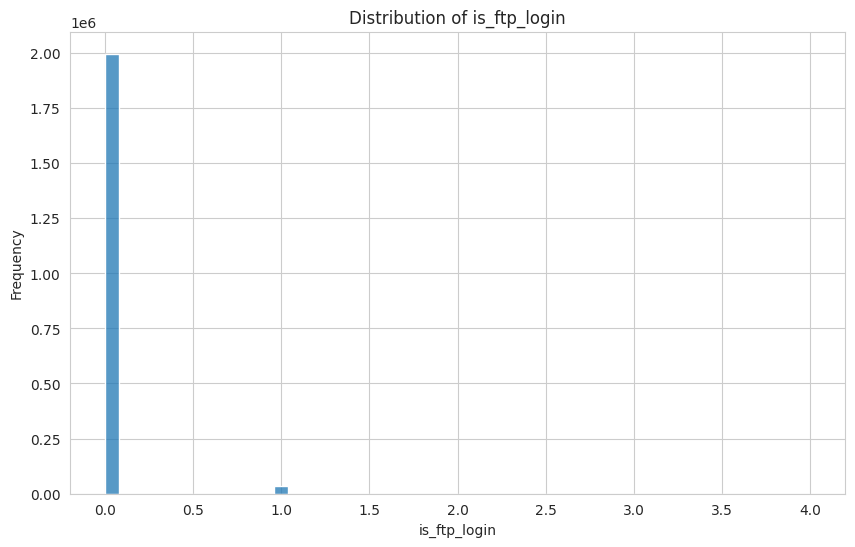

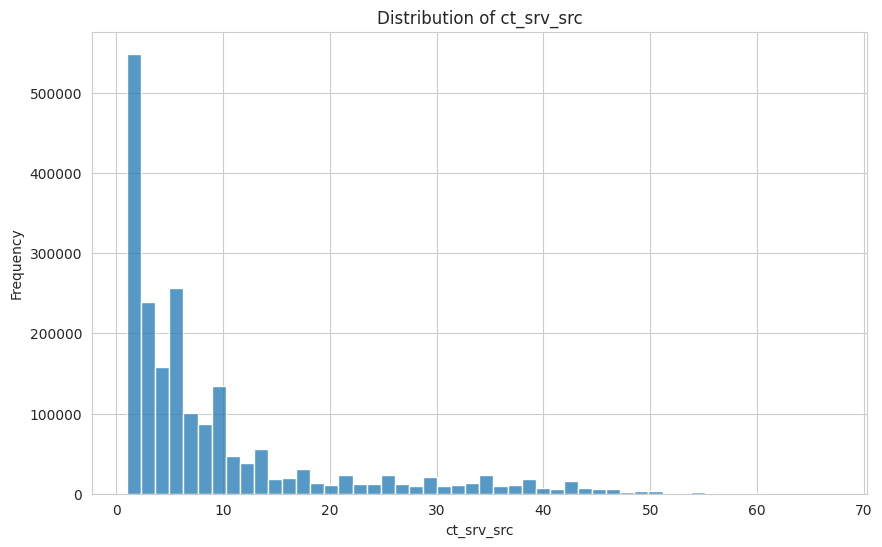

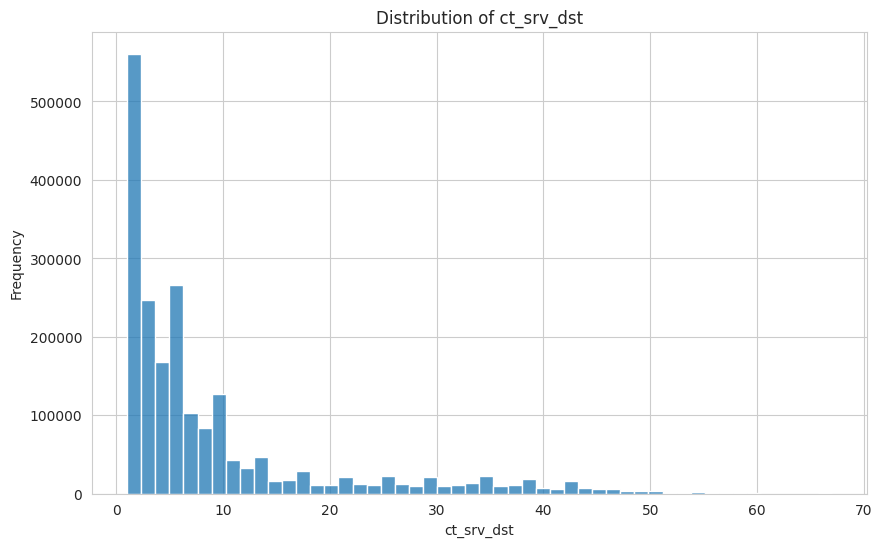

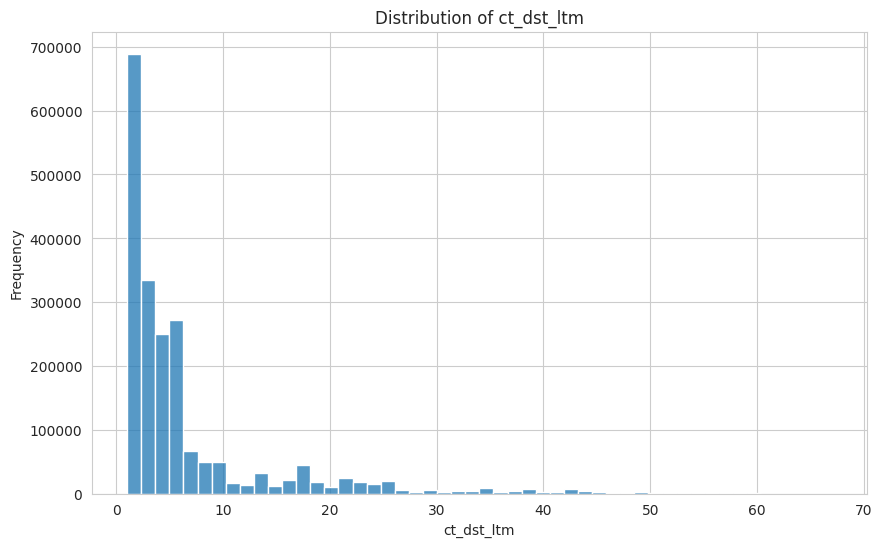

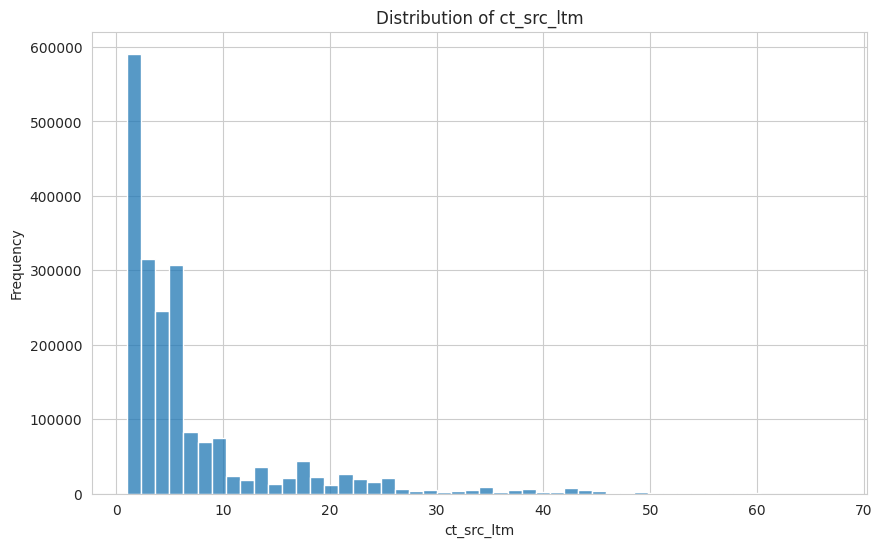

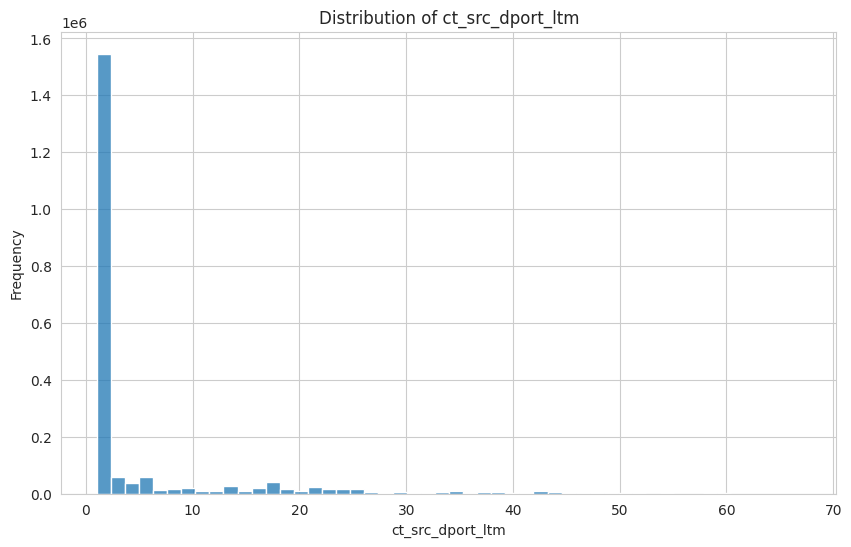

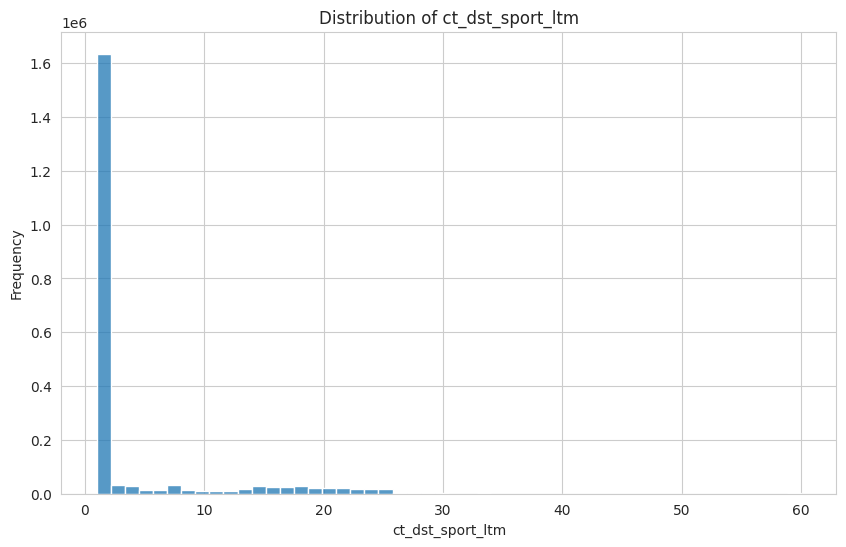

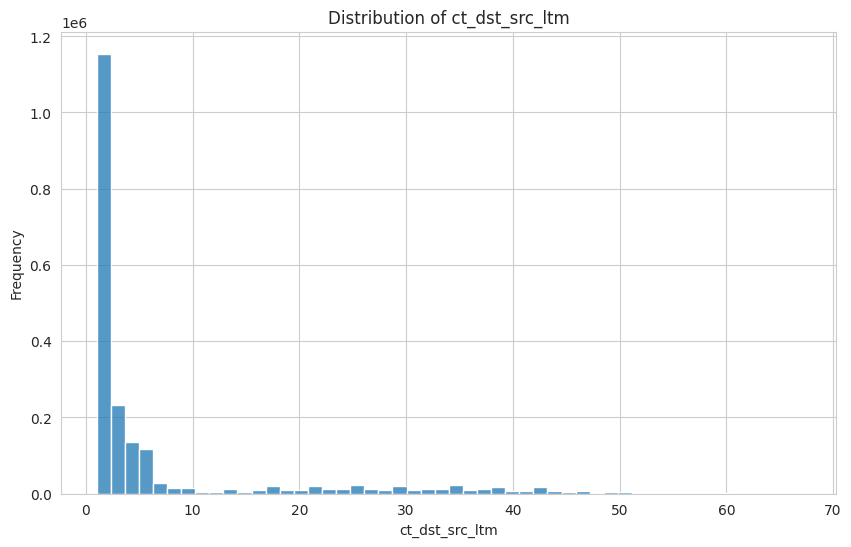

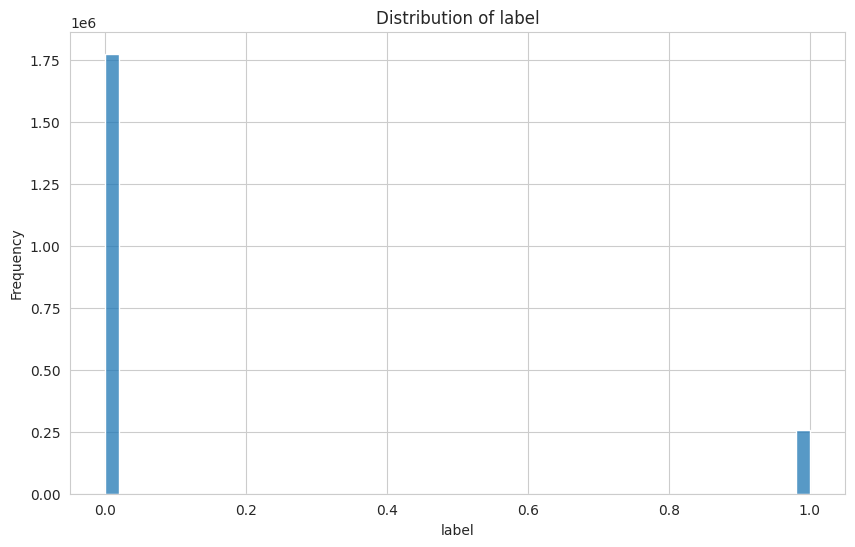

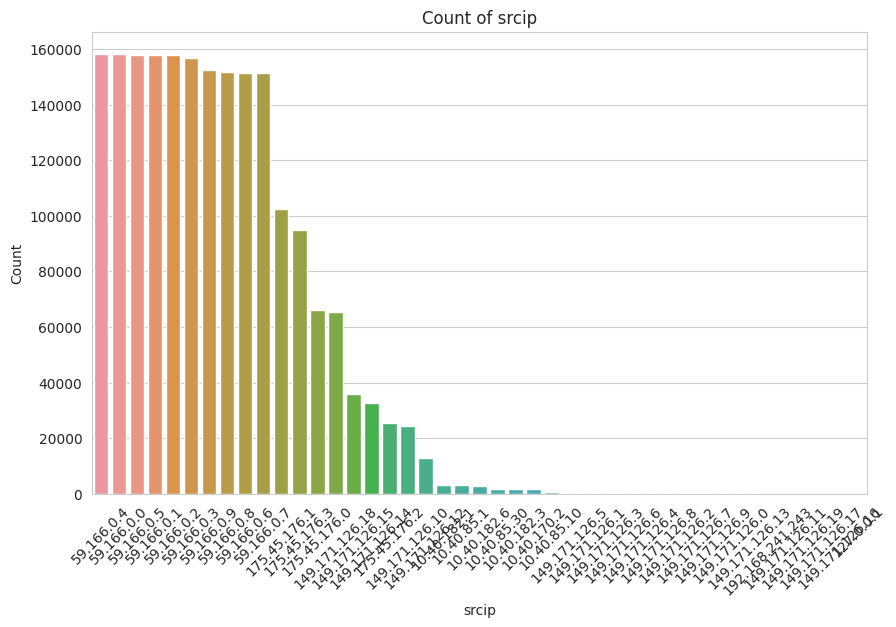

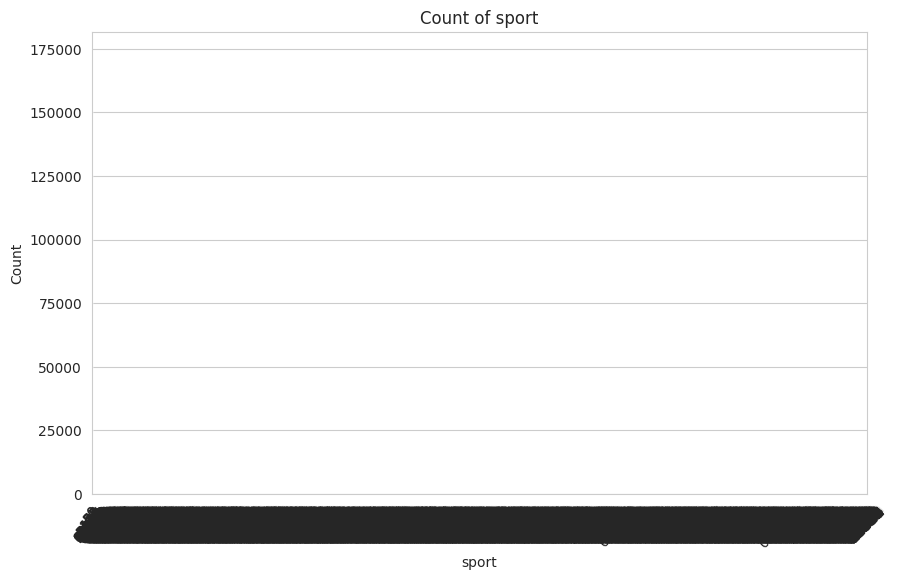

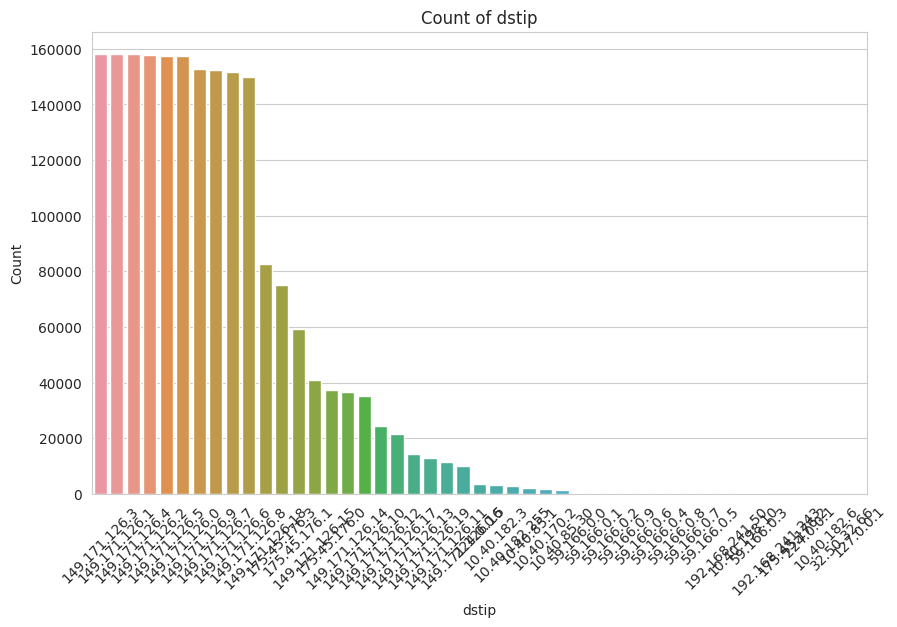

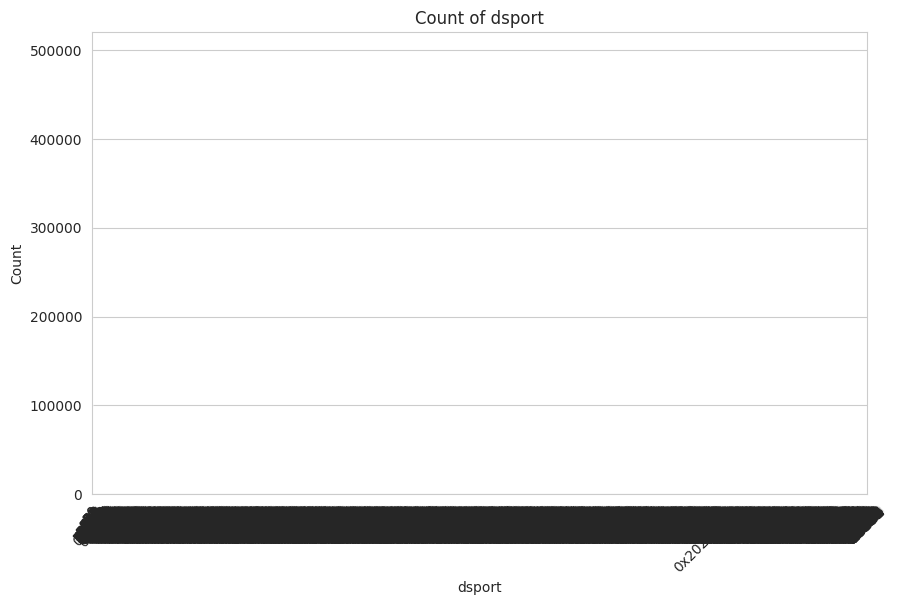

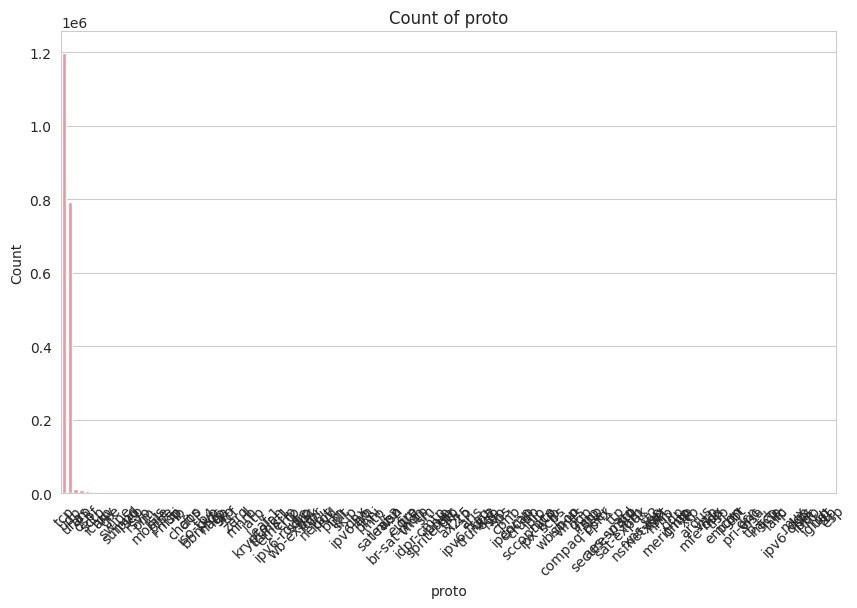

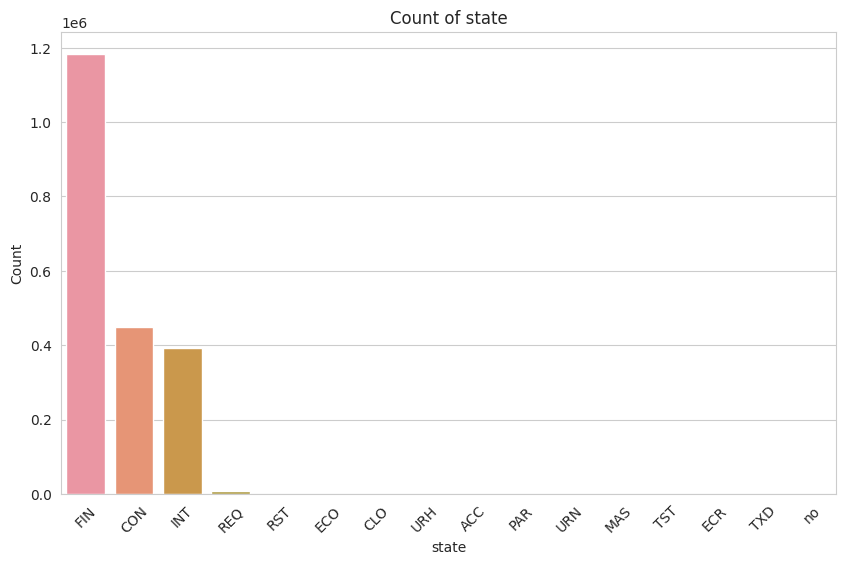

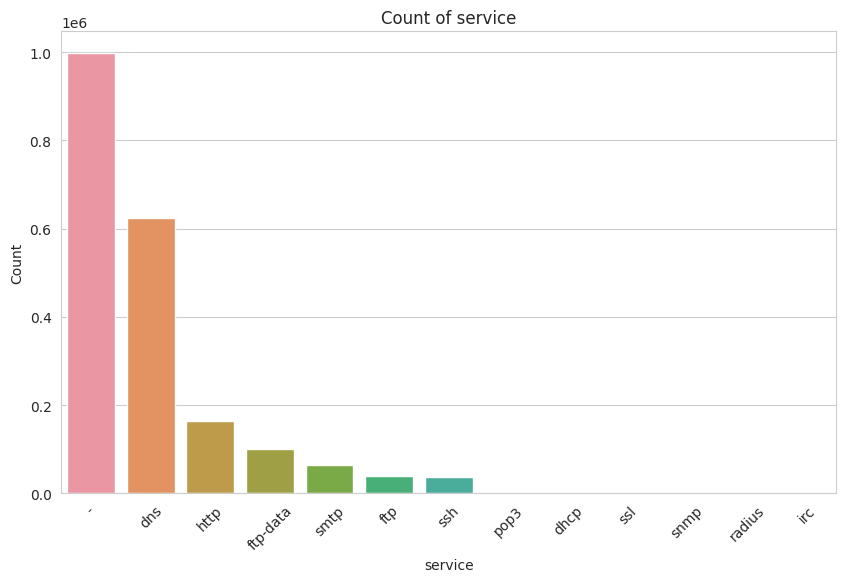

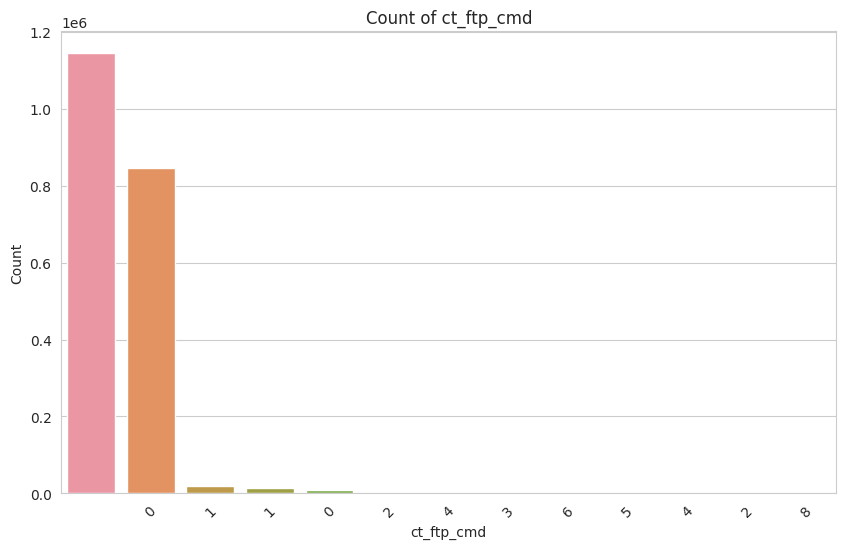

In [ ]:
'''# Set style for seaborn plots
sns.set_style("whitegrid")

# Identify numerical and categorical columns
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Create a list to store the plots
plots = []

# Plotting histograms for numerical columns
for col in numerical_cols:
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(train[col], bins=50, kde=False, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel(col)
    plots.append(plt)

# Plotting bar plots for categorical columns (excluding target 'attack_cat' and 'label')
for col in categorical_cols:
    if col not in ['attack_cat', 'label']:
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.countplot(data=train, x=col, order=train[col].value_counts().index, ax=ax)
        ax.set_title(f'Count of {col}')
        ax.set_ylabel('Count')
        ax.set_xlabel(col)
        ax.tick_params(axis='x', rotation=45)
        plots.append(plt)

# Show plots in batches to avoid clutter
plots[:5]

### Visualisation de la distribution des catégories d'attaques, des protocoles, des états de connexion, de certaines caractéristiques numériques

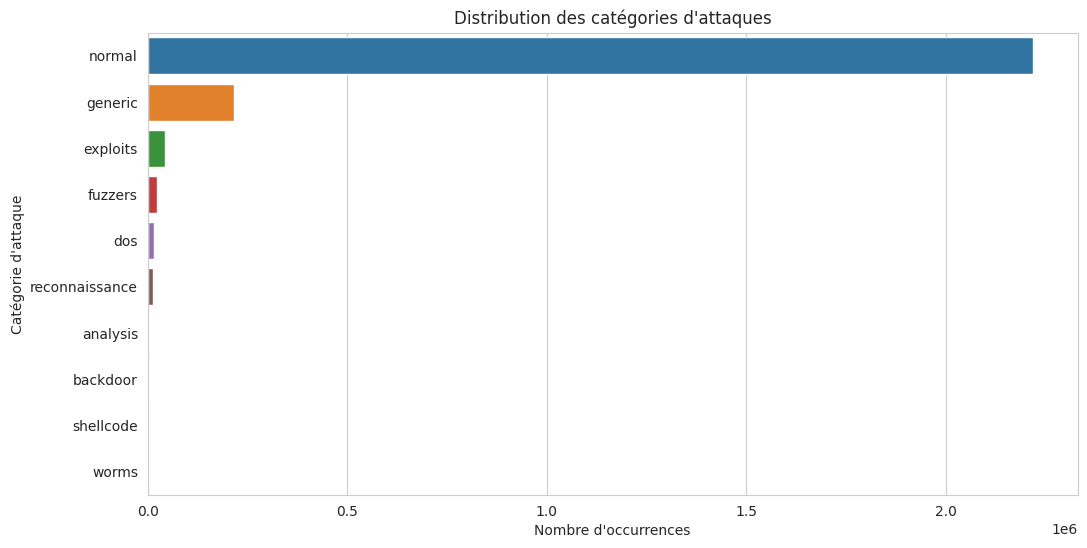

In [ ]:
# Paramètres de style
sns.set_style("whitegrid")

# Visualisation de la distribution des catégories d'attaques
plt.figure(figsize=(12, 6))
sns.countplot(y=train['attack_cat'], order=train['attack_cat'].value_counts().index)
plt.title("Distribution des catégories d'attaques")
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Catégorie d'attaque")
plt.show()

9 familles d'attaques :

Fuzzers : attaque qui utilise des quantités massives de données aléatoires appelées « Fuzz » pour déclencher une panne d'un réseau ou tenter de faire planter des serveurs importants sur un réseau.

Analyse : cette classe contient diverses formes d'attaques basées sur des analyses de ports, des analyses de vulnérabilités, des fichiers spam et des empreintes. On l'appelle également reconnaissance active, où le réseau est analysé d'une manière ou d'une autre mais non exploité.

Portes dérobées : cette catégorie utilise une technique par laquelle les attaquants utilisent un portail système légitime pour obtenir un accès illicite. Les portes dérobées utilisent des logiciels malveillants pour s'installer dans un système informatique et pour fournir un accès à distance aux attaquants dans le cadre d'un exploit.

Déni de service (DoS) : cyberattaque bien connue dans laquelle l'auteur cherche à compromettre une machine avec plusieurs demandes de connexion illégitimes afin de rendre les ressources réseau indisponibles pour ses utilisateurs prévus, temporairement ou définitivement. Celles-ci peuvent être difficiles à distinguer d’une activité réseau légitime ; cependant, il existe certains indicateurs permettant de détecter de telles activités intrusives en cours.

Exploits : les attaques par exploit sont généralement réalisées en ciblant et en compromettant les vulnérabilités connues qui existent dans les systèmes d'exploitation. Un logiciel d'exploitation peut également être utilisé pour automatiser ces attaques une fois qu'une vulnérabilité potentielle est détectée dans un réseau.

Générique : Une attaque basée sur des chiffrements, qui est essentiellement une attaque par collision sur la clé secrète générée par les principes cryptographiques. Cette analyse peut être appliquée aux chiffrements de codes d’authentification par blocs, flux et messages. On parle souvent d'attaque par collision, car la plupart de ces familles sont vulnérables à l'attaque d'anniversaire. L'attaque dépend de la probabilité plus élevée de collisions constatées entre les tentatives d'attaque aléatoires.

Reconnaissance : elle collecte des informations préliminaires sur tout réseau public ou hôte cible et est ensuite utilisée par des techniques d'exploitation pour pénétrer les hôtes ou réseaux cibles en exploitant les informations recueillies. Cette classe utilise des informations librement accessibles au service public « Whois », aux enregistrements ARIN et Shodan. Les recherches sur les réseaux sociaux facilitent les attaques de reconnaissance. On les appelle également reconnaissance passive.

Shellcode : Il s’agit d’un sous-ensemble de l’exploit de classe. Cette attaque utilise un petit morceau de code comme charge utile d'un exploit. Le code malveillant est injecté dans une application active pour compromettre et accéder à distance à l'ordinateur d'une victime. Il démarre généralement un shell de commande à partir duquel l'attaquant peut contrôler la machine compromise.

Vers : un ver est une attaque malveillante qui se propage via la propagation du réseau et infecte assez rapidement un réseau beaucoup plus vaste. Un ver peut également infecter des ordinateurs, puis les transformer en zombies ou en robots, dans le but de les utiliser dans des attaques distribuées via la formation de réseaux de zombies.

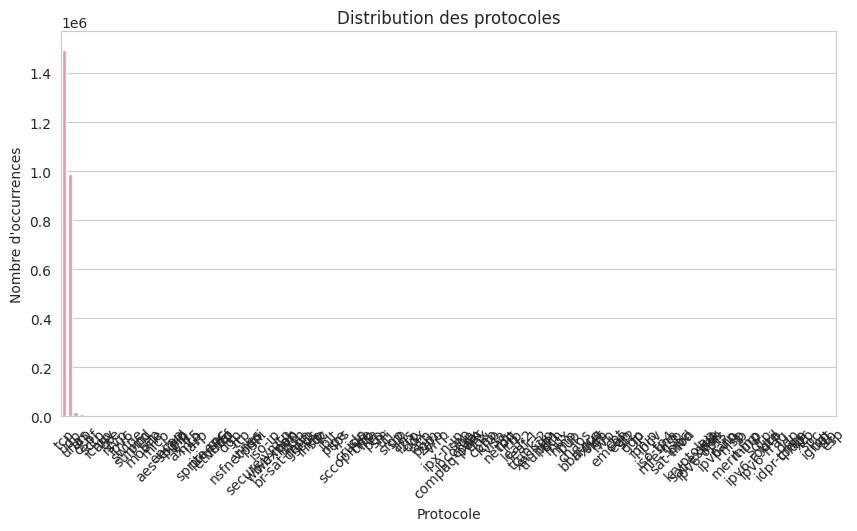

In [ ]:
# Visualisation de la distribution des protocoles
plt.figure(figsize=(10, 5))
sns.countplot(x=train['proto'], order=train['proto'].value_counts().index)
plt.title("Distribution des protocoles")
plt.xlabel("Protocole")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.show()

La visualisation montre que le protocole tcp est le plus couramment utilisé, suivi de udp et unas. Les autres protocoles ont un nombre nettement plus faible d'occurrences.

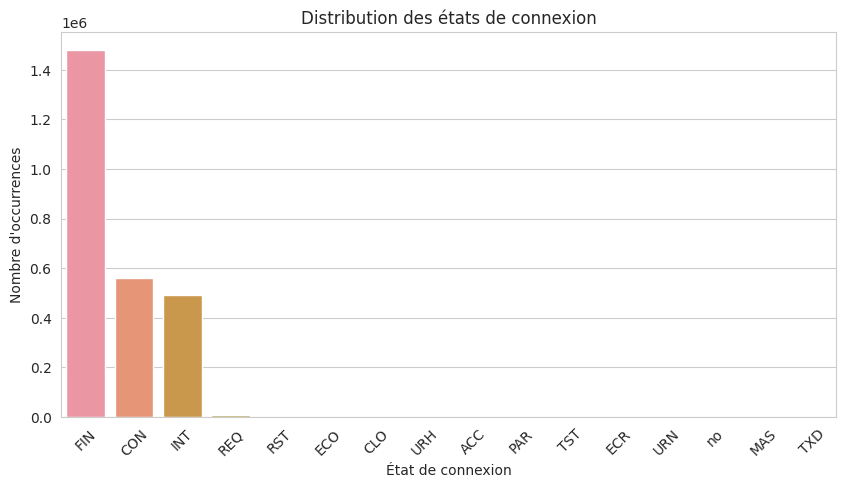

In [ ]:
# Visualisation de la distribution des états de connexion
plt.figure(figsize=(10, 5))
sns.countplot(x=train['state'], order=train['state'].value_counts().index)
plt.title("Distribution des états de connexion")
plt.xlabel("État de connexion")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.show()

La visualisation montre que l'état FIN est le plus courant, suivi de INT. Les autres états ont un nombre d'occurrences beaucoup plus faible.

L'état FIN signifie généralement que la connexion a été établie et terminée normalement, tandis que INT peut indiquer des connexions interrompues ou non initialisées.

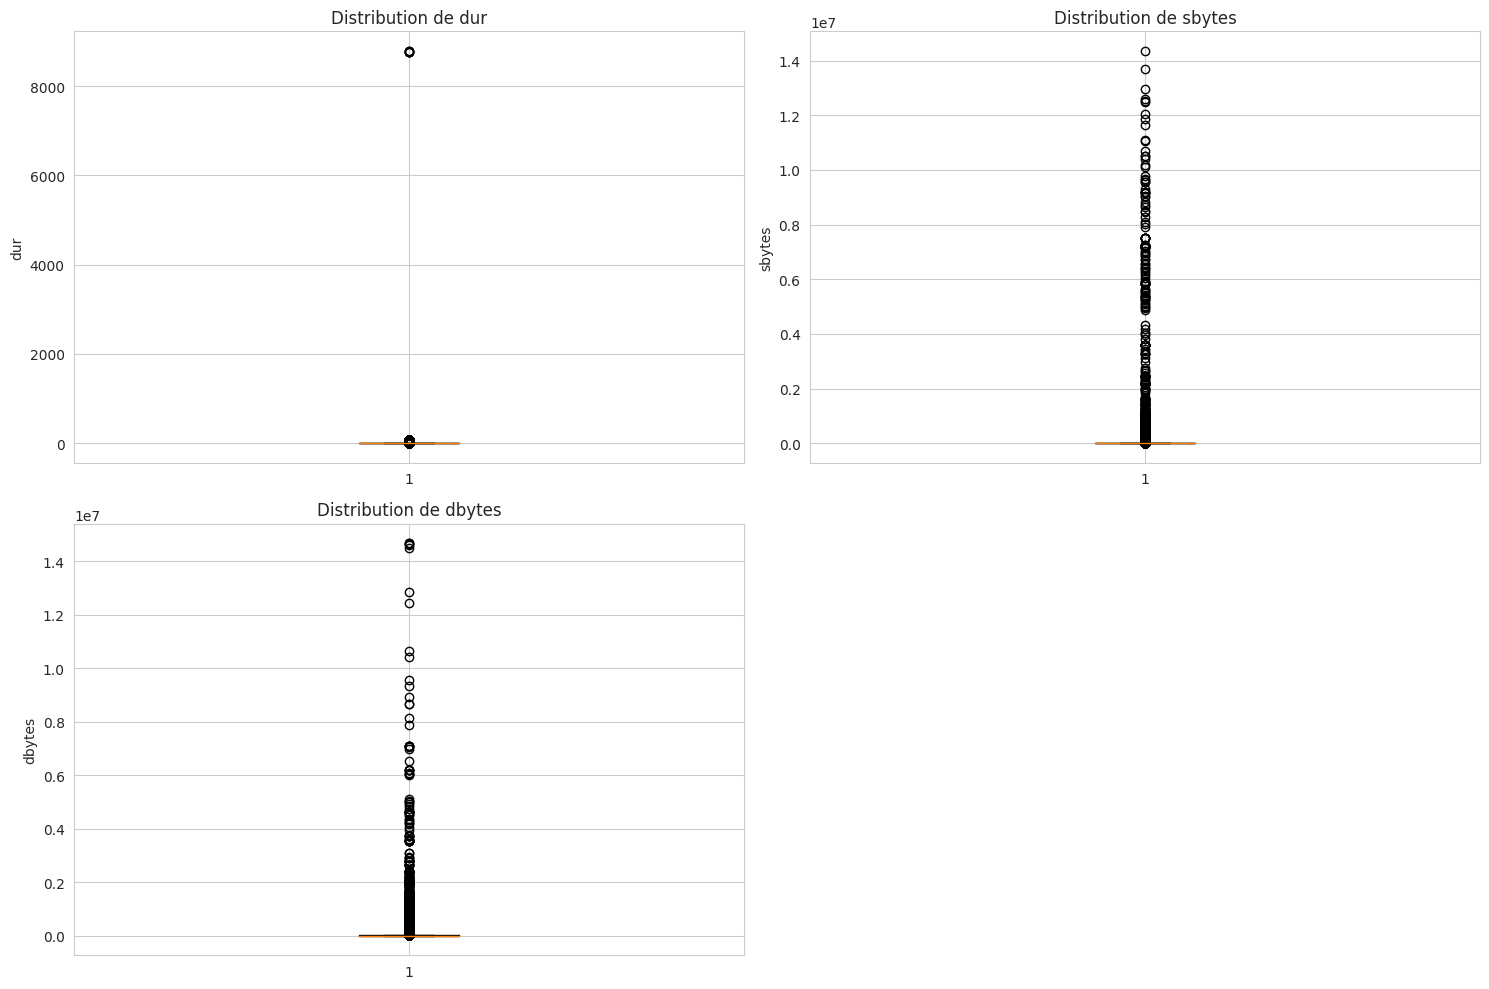

In [ ]:
# Visualisation de la distribution de certaines caractéristiques numériques
features_to_plot = ['dur', 'sbytes', 'dbytes']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(train[feature])
    plt.title(f'Distribution de {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

1.   dur (durée): La plupart des valeurs sont concentrées autour de valeurs faibles, mais il y a quelques points qui s'écartent de la distribution principale. Ces points pourraient être considérés comme des valeurs aberrantes.
2.   sbytes (octets envoyés): De même, la plupart des valeurs sont concentrées autour de valeurs faibles, mais il y a quelques valeurs qui sont nettement plus élevées.
3.   dbytes (octets reçus): La situation est similaire à celle de sbytes.









1.   Prétraitement : Les colonnes contenant des données non numériques (comme proto, state, etc.) doivent être encodées pour être utilisées dans la modélisation.
2.   Division des données : Nous diviserons les données en ensembles d'entraînement et de test.

### Relation entre les protocoles et les types d'attaque

In [ ]:
# Relation entre proto et attack_cat
protocol_attack_relation = pd.crosstab(train['proto'], train['attack_cat'])

# Trier par types d'attaques les plus courantes pour une meilleure visibilité
sorted_columns = protocol_attack_relation.sum().sort_values(ascending=False).index
protocol_attack_relation = protocol_attack_relation[sorted_columns]


protocol_attack_relation

attack_cat,normal,generic,exploits,fuzzers,dos,reconnaissance,analysis,backdoor,shellcode,worms
proto,,,,,,,,,,
3pc,0,6,55,10,44,7,8,7,0,0
a/n,0,6,55,10,44,7,8,7,0,0
aes-sp3-d,0,6,55,10,44,7,8,7,0,0
any,0,18,165,30,132,21,24,21,0,0
argus,0,6,55,10,44,7,8,7,0,0
...,...,...,...,...,...,...,...,...,...,...
wsn,0,6,55,10,44,7,8,7,0,0
xnet,0,6,55,10,44,7,8,7,0,0
xns-idp,0,6,55,10,44,7,8,7,0,0


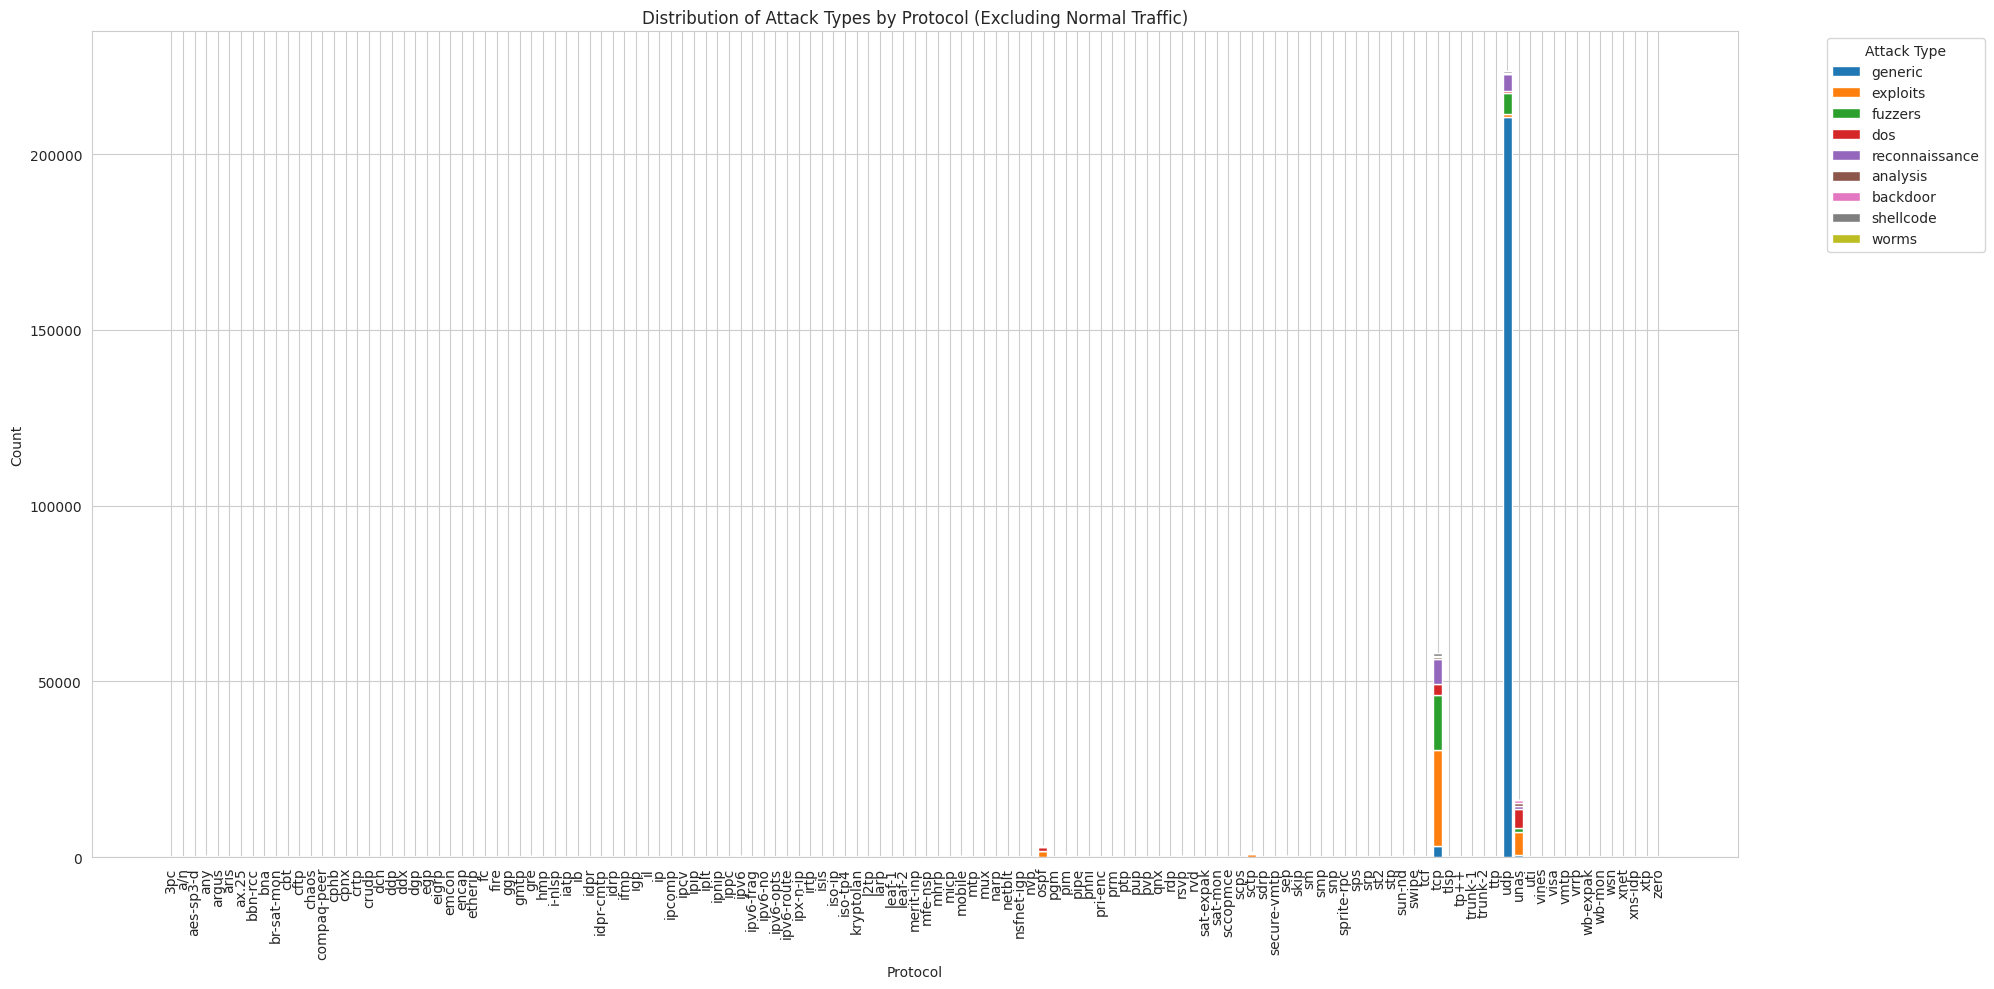

In [ ]:
# Remove 'normal' column
protocol_attack_relation_filtered = protocol_attack_relation.drop(columns=['normal'])

# Filter out protocols that only have 'normal' traffic
protocol_attack_relation_filtered = protocol_attack_relation_filtered[protocol_attack_relation_filtered.sum(axis=1) > 0]

# Set up the figure and axis
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Data for stacked bar plot
bottom = np.zeros(len(protocol_attack_relation_filtered))

# Plot each attack type as a segment of the stacked bar
for column in protocol_attack_relation_filtered.columns:
    ax.bar(protocol_attack_relation_filtered.index, protocol_attack_relation_filtered[column], label=column, bottom=bottom)
    bottom += protocol_attack_relation_filtered[column]

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Labeling and showing the plot
plt.title("Distribution of Attack Types by Protocol (Excluding Normal Traffic)")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.legend(title="Attack Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

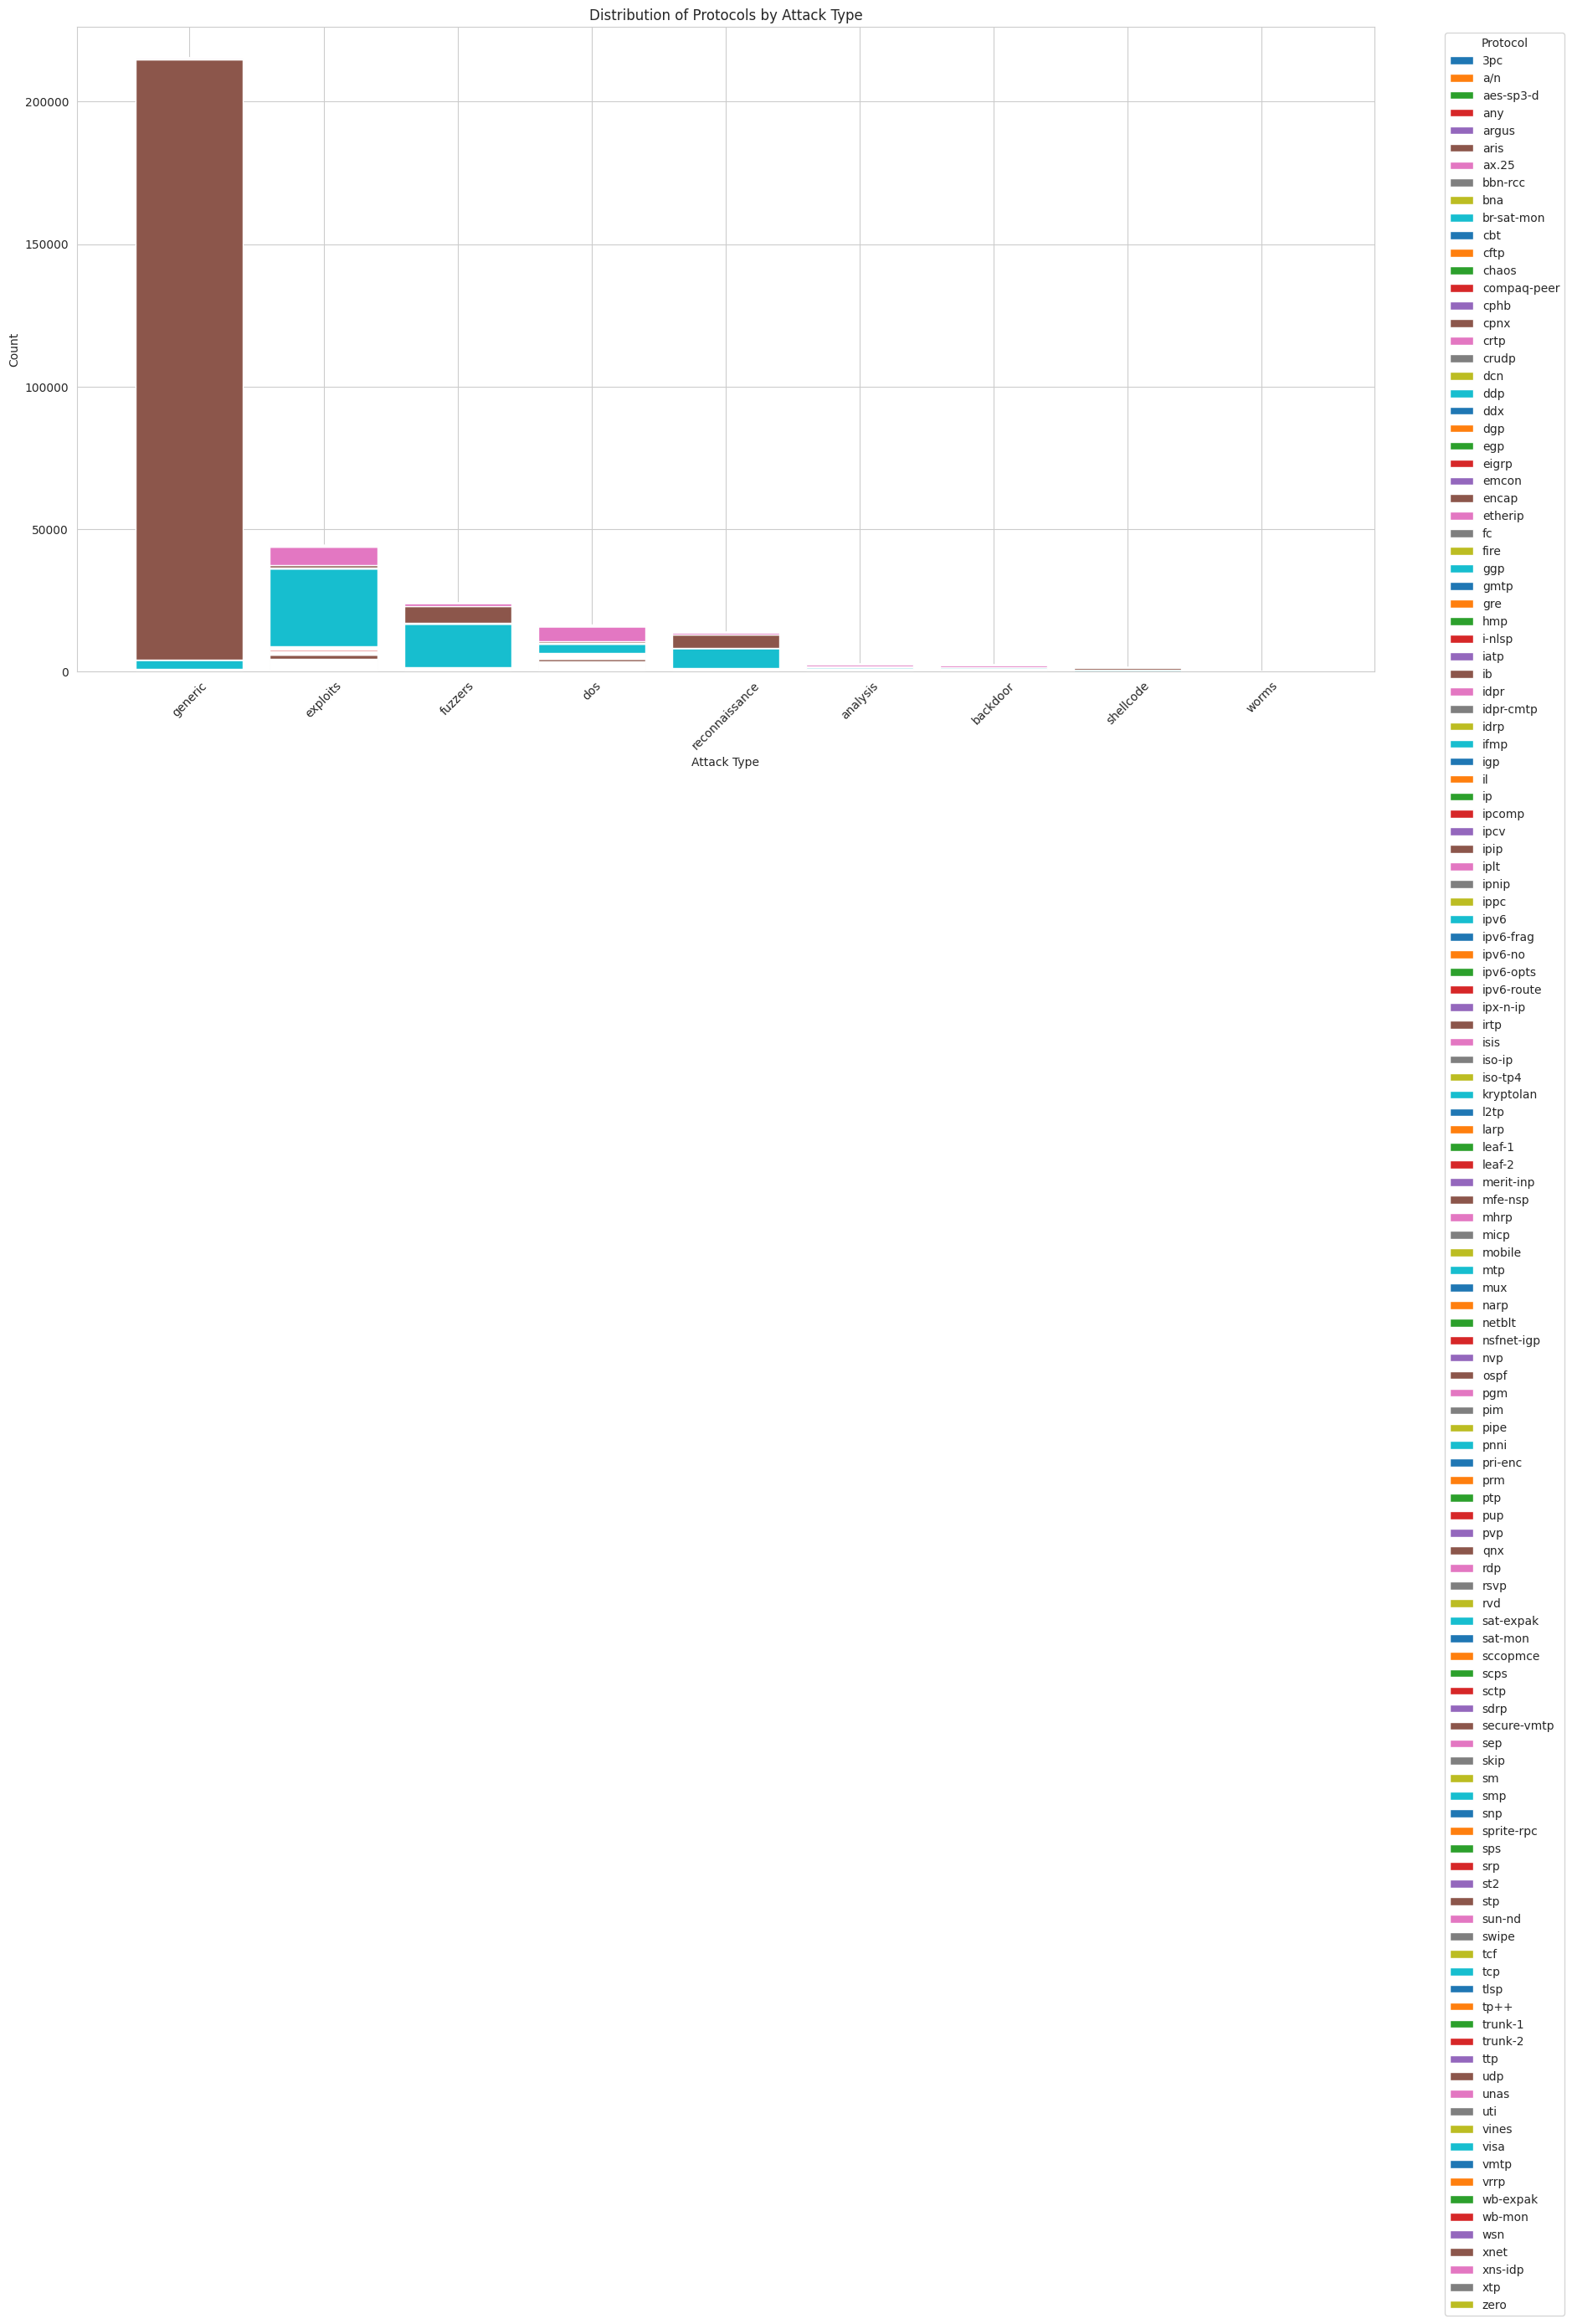

In [ ]:
# Transpose the dataframe for plotting
protocol_attack_transposed = protocol_attack_relation_filtered.transpose()

# Set up the figure and axis
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Data for stacked bar plot
bottom = np.zeros(len(protocol_attack_transposed))

# Plot each attack type as a segment of the stacked bar
for column in protocol_attack_transposed.columns:
    ax.bar(protocol_attack_transposed.index, protocol_attack_transposed[column], label=column, bottom=bottom)
    bottom += protocol_attack_transposed[column]

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Labeling and showing the plot
plt.title("Distribution of Protocols by Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.legend(title="Protocol", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

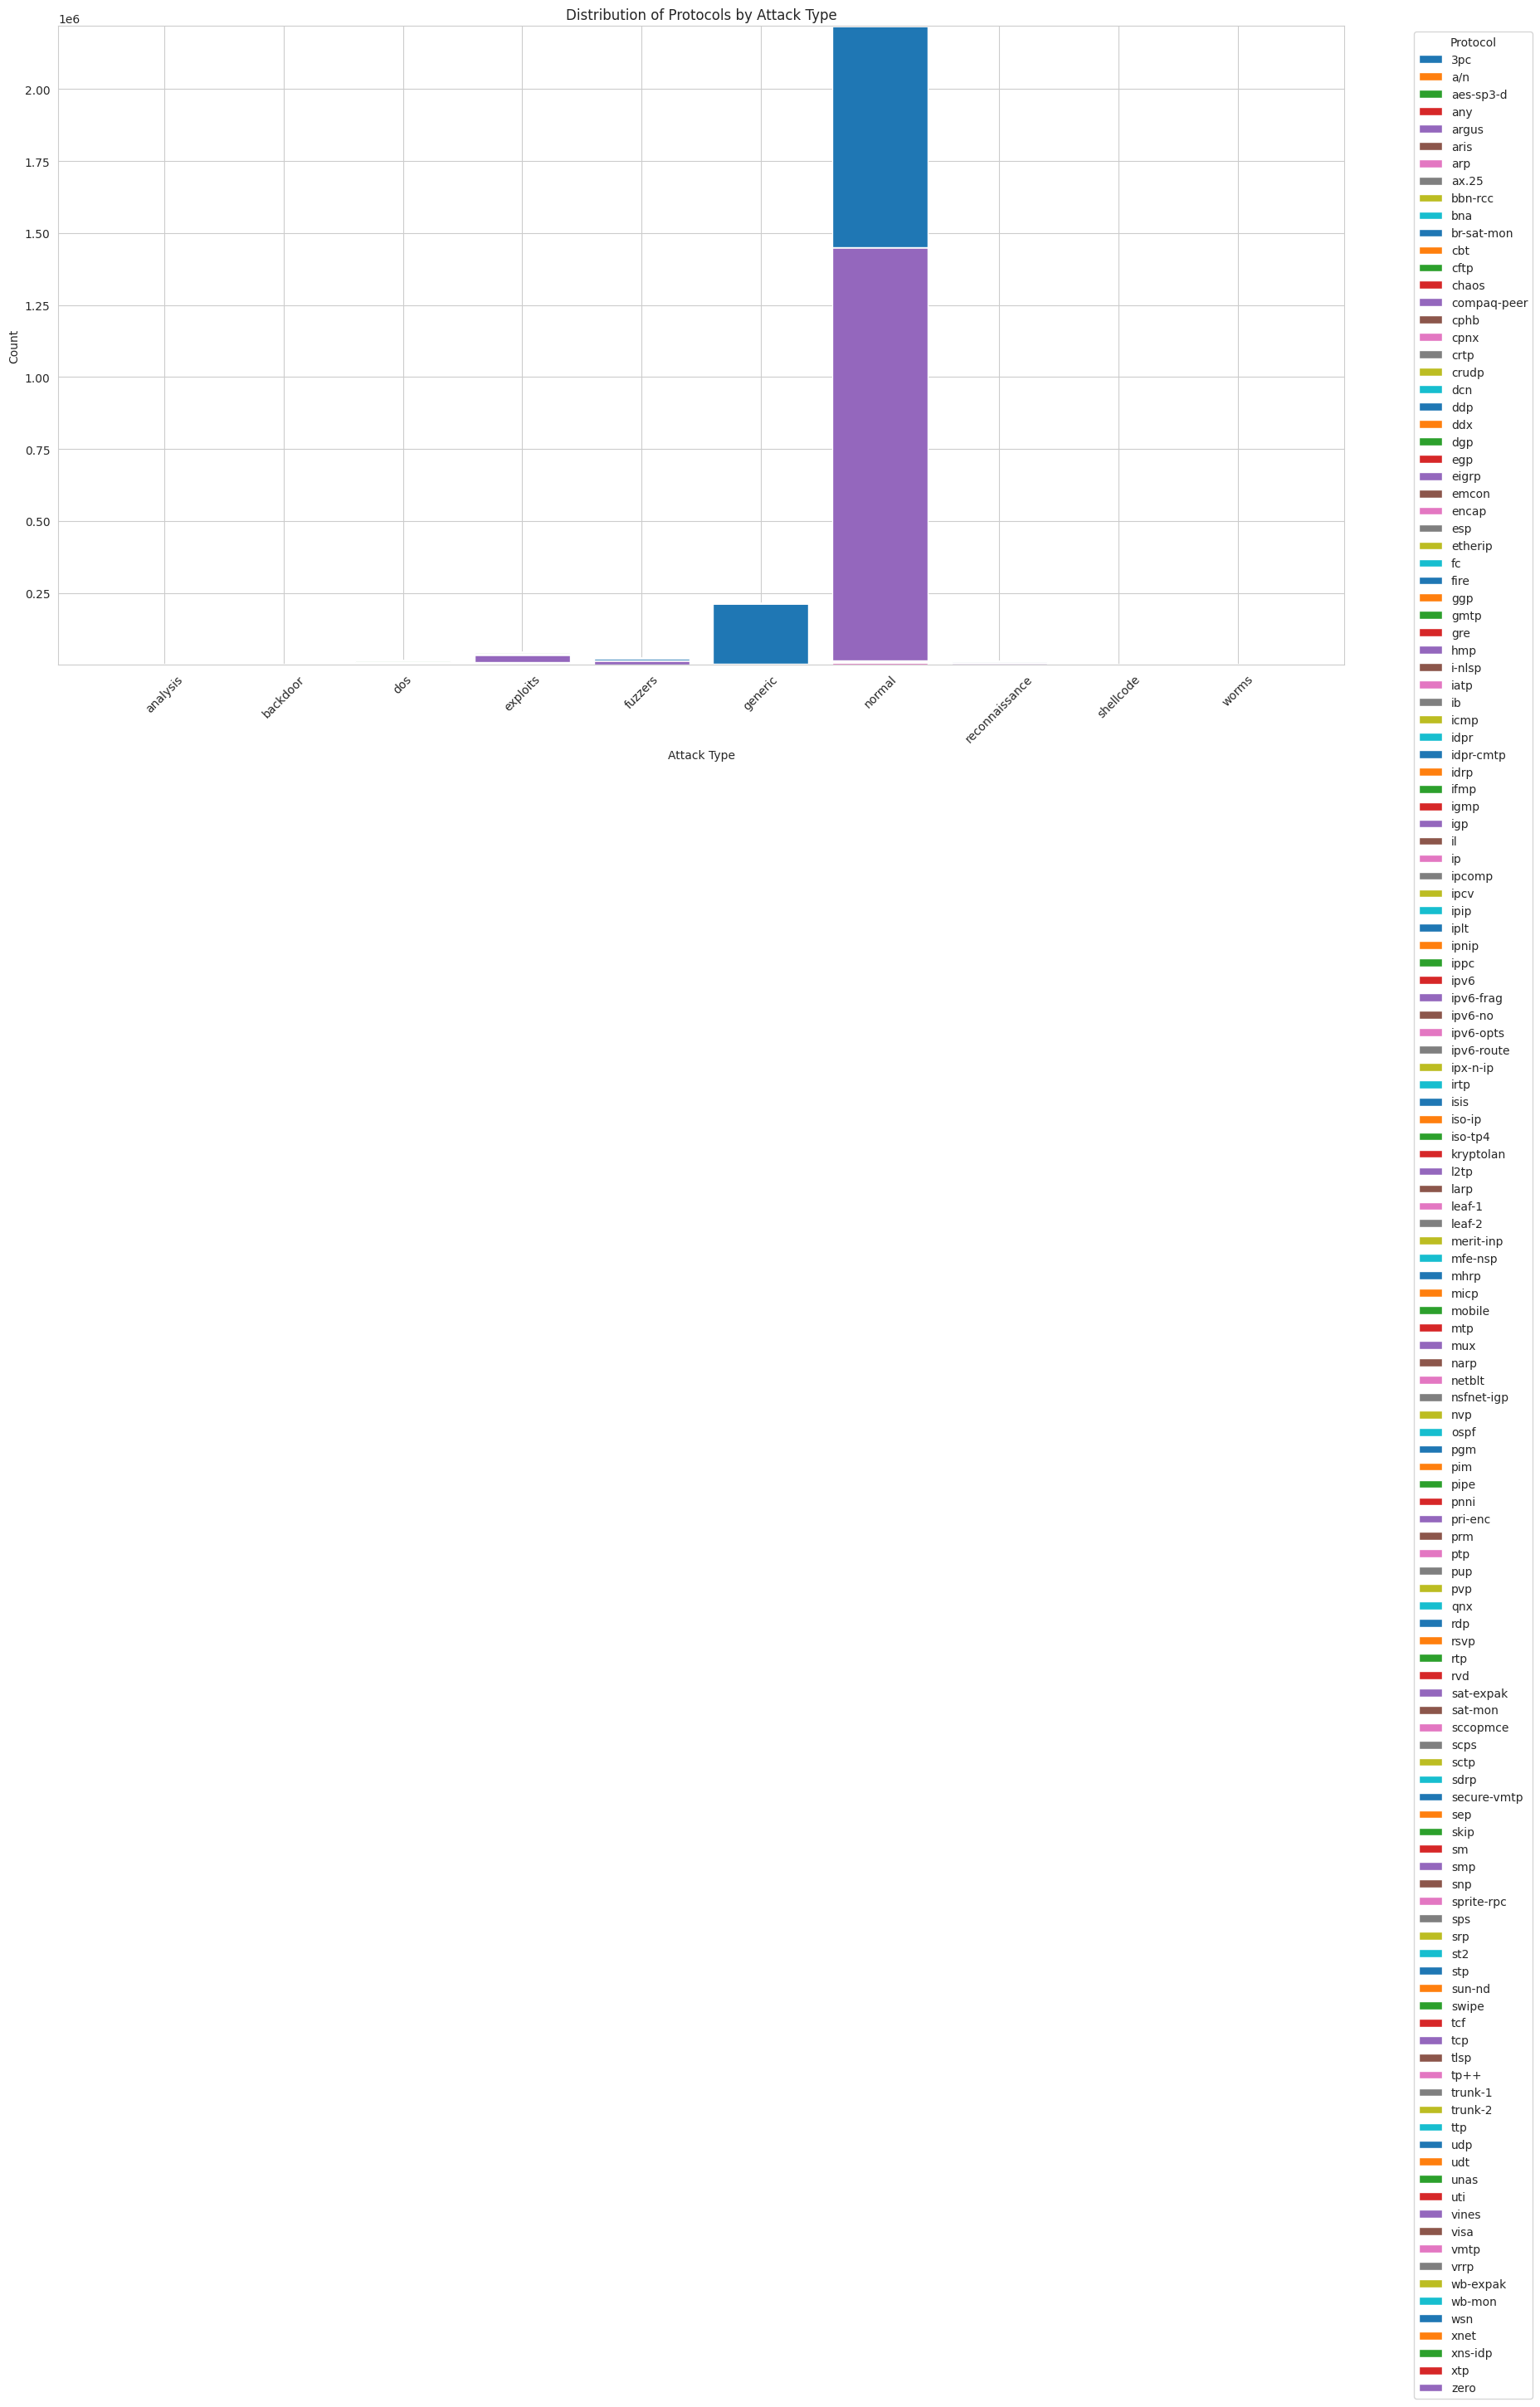

In [ ]:
# Extract the protocol-attack relation again
protocol_attack_relation = train.groupby('proto')['attack_cat'].value_counts().unstack().fillna(0)

# Remove 'normal' column and filter out protocols that only have 'normal' traffic
protocol_attack_relation_filtered = protocol_attack_relation.drop(columns=['Normal'], errors='ignore')
protocol_attack_relation_filtered = protocol_attack_relation_filtered[protocol_attack_relation_filtered.sum(axis=1) > 0]

# Transpose the dataframe for plotting
protocol_attack_transposed = protocol_attack_relation_filtered.transpose()

# Create the plot
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
bottom = np.zeros(len(protocol_attack_transposed))

for column in protocol_attack_transposed.columns:
    ax.bar(protocol_attack_transposed.index, protocol_attack_transposed[column], label=column, bottom=bottom)
    bottom += protocol_attack_transposed[column]

plt.xticks(rotation=45)
plt.title("Distribution of Protocols by Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.legend(title="Protocol", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

La majorité des protocoles ont principalement du trafic normal.
Certains protocoles, tels que arp, présentent uniquement du trafic normal dans cet échantillon. D'autres protocoles, comme 3pc, ont des occurrences d'attaques de type dos. Le protocole tcp présente la plus grande diversité d'attaques.Certains protocoles, comme ospf, sctp, et sun-nd, ont des distributions d'attaques uniques qui diffèrent des autres.

##-- MACHINE LEARNING --

    KNN (k-Nearest Neighbors) : C'est un algorithme de classification basé sur la distance. Il pourrait être utile, mais il peut ne pas être le plus efficace en termes de temps de calcul avec de grands ensembles de données.

    DB-SCAN : C'est un algorithme de clustering. Il n'est pas typiquement utilisé pour la classification, mais il pourrait être utilisé pour identifier des groupes d'activités similaires dans les données.

    Régression linéaire : C'est généralement utilisé pour la régression (prédiction d'une valeur continue) et non pour la classification. Dans ce cas, nous voulons prédire une étiquette binaire (normal vs. attaque), donc ce n'est pas le meilleur choix.

    Arbres de décision, Forêts aléatoires et Machines à gradient boosting : Ce sont de bons choix pour la classification et peuvent gérer à la fois des caractéristiques numériques et catégorielles.

    Réseaux de neurones : Ils peuvent être puissants, mais nécessitent une optimisation et un réglage appropriés. Ils pourraient être un bon choix si les autres méthodes ne fonctionnent pas bien.

D'autres algorithmes qui pourraient être utiles :

    Machine à vecteurs de support (SVM) : Elle peut être efficace pour la classification binaire.
    XGBoost : Une variante optimisée des machines à gradient boosting.

Préparation :
- One-hot encoder pour diviser attack_cat en 1 colonne/attaque et normal,
- Division du set en train et test.

In [ ]:
'''# Conversion des colonnes catégoriques en numérique en utilisant one-hot encoding
categorical_columns = ['proto', 'state']
train = pd.get_dummies(train, columns=categorical_columns, drop_first=True)

train.shape'''

Méthode StandardScaler de scikit-learn, la "normalisation" signifie :

- Centrage : Soustraire la moyenne de chaque caractéristique de l'ensemble de données à chaque valeur de cette caractéristique. Cela déplace la distribution de chaque caractéristique pour qu'elle ait une moyenne de zéro.

- Mise à l'échelle : Diviser chaque valeur de la caractéristique par l'écart-type de cette caractéristique. Cela fait en sorte que la distribution de chaque caractéristique ait un écart-type de un.

Mathématiquement, pour chaque valeur x d'une caractéristique, la valeur normalisée x' est donnée par :

x' =(x - moyenne)/écart-type

Où :
- x est la valeur originale de la caractéristique.
- moyenne est la moyenne de cette caractéristique sur l'ensemble d'entraînement.
- écart-type est l'écart-type de cette caractéristique sur l'ensemble d'entraînement.

Avantages de la normalisation :
- Elle aide à accélérer la convergence lors de l'utilisation d'algorithmes basés sur des gradients, comme la descente de gradient.
- Elle garantit que toutes les caractéristiques ont le même poids, surtout dans les algorithmes sensibles à l'échelle des caractéristiques, comme KNN, SVM ou les réseaux de neurones.

À noter : Lors de la normalisation, il est crucial d'utiliser la moyenne et l'écart-type calculés sur l'ensemble d'entraînement pour transformer à la fois l'ensemble d'entraînement et l'ensemble de test. Cela garantit que l'ensemble de test est transformé de la même manière que l'ensemble d'entraînement, sans introduire de "fuite d'information" de l'ensemble de test vers l'ensemble d'entraînement.

In [1]:
# Nbre de valeurs uniques présentes dans la colonne attack_cat = nombre de nouvelles colonnes seront générées.
unique_attack_categories = train['attack_cat'].unique()

unique_attack_categories

NameError: ignored

In [ ]:
#New

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# One-hot encode pour la colonne 'attack_cat'
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_attack_cat = encoder.fit_transform(train[['attack_cat']])
encoded_columns = encoder.get_feature_names_out(['attack_cat'])
encoded_df = pd.DataFrame(encoded_attack_cat, columns=encoded_columns)

# Drop the original 'attack_cat' column and concatenate the encoded dataframe
train = pd.concat([train.drop('attack_cat', axis=1), encoded_df], axis=1)

# Convert other categorical columns to numeric using pandas get_dummies
categorical_columns = ['proto', 'state']
train = pd.get_dummies(train, columns=categorical_columns, drop_first=True)

# Split the data into training and test sets (80% train, 20% test)
X = train.drop('label', axis=1)
y = train['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Normalize the numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

## Matrice de corrélation
Pour vérifier la corrélation entre toutes les informations, retirer les doublons, épurer le nombre de colonnes

In [ ]:
'''# Division des données en ensembles d'entraînement et de test
X = data_ml.drop(columns='label')
y = data_ml['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape'''

# Prétraitement sans retirer 'attack_cat'
cols_to_drop = ['srcip', 'dstip']
data_ml = train.drop(columns=cols_to_drop)

# Définition du seuil
threshold = 0.9
# Encodage des variables catégorielles
label_encoders = {}
categorical_cols = data_ml.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    data_ml[col] = le.fit_transform(data_ml[col])
    label_encoders[col] = le

# Calcul de la matrice de corrélation
correlation_matrix = data_ml.drop(columns='label').corr()

# Identification des caractéristiques fortement corrélées
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

correlated_features

{'ackdat',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_src_dport_ltm',
 'ct_src_ltm',
 'ct_srv_dst',
 'ct_state_ttl',
 'dloss',
 'dpkts',
 'dwin',
 'ltime',
 'sloss',
 'synack'}

## One-hot encoding

Avant de procéder à l'apprentissage automatique, il est crucial de transformer les données catégorielles en format numérique, car la plupart des algorithmes de machine learning ne peuvent pas traiter directement les données textuelles. Une technique courante est l'encodage à chaud (one-hot encoding).

Utiliser pd.get_dummies() pour créer les colonnes binaires

In [ ]:
print(train['attack_cat'])

In [ ]:
train = pd.get_dummies(train, columns=['attack_cat'], prefix='', prefix_sep='')

Maintenant, chaque valeur unique de "attack_cat" a sa propre colonne binaire.
Les valeurs seront 1 si elles correspondent à la catégorie respective et 0 sinon.

(train['attack_cat']) a disparu !

In [ ]:
print(train)

Trie des dernières colonnes par fréquence d'attaques (+ de valeur 1 dans les colonnes)

In [ ]:
# Compter le nombre de 1 dans chaque colonne, parmi les 10 dernières
counts = train.iloc[:, -10:].sum()

# Trier les colonnes en fonction des comptages (du plus grand au plus petit)
train_trie = train[sorted(train.columns[-10:], key=lambda col: counts[col], reverse=True)]

# Afficher le DataFrame trié
print(train_trie)

In [ ]:
#!pip install plotly

In [ ]:
import plotly.express as px
# Créez un DataFrame avec des noms de colonnes et les comptages correspondants
counts = train_trie.iloc[:, -10:].sum()
df_counts = pd.DataFrame({'Colonne': counts.index, 'Comptage': counts.values})

# Créez un diagramme Sunburst
fig = px.sunburst(df_counts, path=['Colonne'], values='Comptage')

# Affichez le diagramme
fig.show()

# Créez un graphique camembert à partir du DataFrame df_counts
fig = px.pie(df_counts, names='Colonne', values='Comptage', title="Répartition du nombre d'attaques")

# Affichez le graphique camembert
fig.show()

In [ ]:
# Créez un graphique camembert à partir du DataFrame df_counts
fig = px.pie(df_counts, names='Colonne', values='Comptage', title="Répartition du nombre d'attaques")

# Affichez le graphique camembert
fig.show()

La visualisation montre la distribution des différentes catégories d'attaques dans notre échantillon de données. La catégorie "normal" domine, ce qui signifie que la plupart des enregistrements correspondent à un trafic réseau normal.

In [ ]:
import plotly.express as px

# Créez un DataFrame avec des catégories de base, catégories liées à l'attaque et catégories génériques
df_categories_counts = train_trie.map(categorie_mapping).value_counts().reset_index()
df_categories_counts.columns = ['Catégorie', 'Comptage']

# Créez un diagramme Sunburst en utilisant le DataFrame des catégories
fig = px.sunburst(df_categories_counts, path=['Catégorie'], values='Comptage')

# Ajoutez un titre au diagramme
fig.update_layout(title="Répartition du nombre d'attaques par catégorie (avec secteur intermédiaire)")

# Affichez le diagramme Sunburst
fig.show()

## Boxplot
L'une des méthodes les plus courantes pour analyser la relation entre une caractéristique catégorielle et une caractéristique continue est de tracer un diagramme en boîte.

In [ ]:
from string import ascii_letters
'''import seaborn as sns
import matplotlib.pyplot as plt'''

sns.set_theme(style="white")

# Calculer la matrice de corrélation
corr = train.corr()

# Générer un masque pour le triangle supérieur qui n'est qu'une symétrie
mask = np.triu(np.ones_like(corr, dtype=bool))

# Mise en place de la figure matplotlib
f, ax = plt.subplots(figsize=(12,12))

# Générer une personnalisée "diverging colormap"
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dessinez la carte thermique avec le masque et le bon rapport hauteur/largeur.
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, #vmax=.3,
            square=True) #, linewidths=.5, cbar_kws={"shrink": .5}

NameError: ignored

> La matrice de corrélation est une représentation des corrélations entre toutes les paires de colonnes de votre DataFrame. Plus la valeur de corrélation est proche de 1 (ou -1), plus les deux colonnes sont fortement corrélées (positivement ou négativement). Une corrélation proche de 0 indique une faible corrélation.





In [ ]:
# Seuil de corrélation (par exemple, 0,5)
seuil_corr = 0.9

# Identifiez les paires de colonnes corrélées
colonnes_corr = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > seuil_corr:
            colonnes = corr.columns[i], corr.columns[j]
            colonnes_corr.add(colonnes)

# Affichez les paires de colonnes corrélées
print("Colonnes corrélées :")
for colonnes in colonnes_corr:
    print(colonnes)

In [ ]:
# Affichez les valeurs de corrélation élevées
print("Valeurs de corrélation élevées :")
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > seuil_corr:
            print(f"{corr.columns[i]} - {corr.columns[j]} : {corr.iloc[i, j]}")

Les corrélations élevées suggèrent qu'il y a une redondance d'informations entre certaines paires de colonnes. Pour optimiser le sous-ensemble de colonnes, cette approche retire les colonnes qui ont des corrélations élevées, en ne conservant qu'une seule colonne de chaque paire.

In [ ]:
# Liste des colonnes fortement corrélées à retirer
colonnes_a_retirer = ['sbytes', 'dloss', 'dpkts', 'dwin', 'ltime', 'tcprtt', 'ct_srv_dst', 'ct_src_ltm', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'sttl']

# Créer un sous-dataframe avec les colonnes restantes
train = train.drop(colonnes_a_retirer, axis=1)

# Afficher les premières lignes du DataFrame optimisé
print(train.head())

In [ ]:
import plotly.express as px

# Créez un DataFrame avec des catégories de base, catégories liées à l'attaque et catégories génériques
df_categories_counts = train_trie['Catégorie'].map(categorie_mapping).value_counts().reset_index()
df_categories_counts.columns = ['Catégorie', 'Comptage']

# Créez un diagramme Sunburst en utilisant le DataFrame des catégories
fig = px.sunburst(df_categories_counts, path=['Catégorie'], values='Comptage')

# Ajoutez un titre au diagramme
fig.update_layout(title="Répartition du nombre d'attaques par catégorie (avec secteur intermédiaire)")

# Affichez le diagramme Sunburst
fig.show()

In [ ]:
# Créez un dictionnaire de correspondance des catégories
categorie_mapping = {
    'Normal': 'Catégorie de base',
    'Fuzzers': 'Catégorie liée à l\'attaque',
    'Analysis': 'Catégorie de base',
    'Backdoors': 'Catégorie liée à l\'attaque',
    'DoS': 'Catégorie liée à l\'attaque',
    'Exploits': 'Catégorie liée à l\'attaque',
    'Generic': 'Catégorie générique',
    'Reconnaissance': 'Catégorie liée à l\'attaque',
    'Shellcode': 'Catégorie liée à l\'attaque',
    'Worms': 'Catégorie liée à l\'attaque'
}

# Ajoutez une nouvelle colonne 'Catégorie' en remplaçant les noms de colonnes par les catégories correspondantes
train_trie['Catégorie'] = train_trie['Colonne'].replace(categorie_mapping)

# Affichez le DataFrame avec la nouvelle colonne de catégories
print(train_trie)

Ce code utilise le DataFrame df_categories_counts pour créer un sunburst en regroupant les attaques par catégorie. Vous pouvez personnaliser le titre du diagramme en modifiant la valeur de title dans la fonction update_layout.

In [ ]:
import plotly.express as px

# Créez un DataFrame avec des catégories et les comptages correspondants
df_categories_counts = train_trie['Catégorie'].value_counts().reset_index()
df_categories_counts.columns = ['Catégorie', 'Comptage']

# Créez un diagramme Sunburst en utilisant le DataFrame des catégories
fig = px.sunburst(df_categories_counts, path=['Catégorie'], values='Comptage')

# Ajoutez un titre au diagramme
fig.update_layout(title="Répartition du nombre d'attaques par catégorie")

# Affichez le diagramme Sunburst
fig.show()

NameError: ignored

## Recherche de l'adresse IP en fonction de l'attaque

In [ ]:
# Colonne 'srcip' et 'dstip' pour les adresses IP source et destination

# Obtenez les catégories uniques de 'attack_cat'
categories_uniques = train['attack_cat'].unique()

# Parcourez chaque catégorie et imprimez les adresses IP correspondantes
for categorie in categories_uniques:
    adresses_ip_source = train.loc[train['attack_cat'] == categorie, 'srcip'].unique()
    adresses_ip_destination = train.loc[train['attack_cat'] == categorie, 'dstip'].unique()
    nadresses_ip_source = train.loc[train['attack_cat'] == categorie, 'srcip'].nunique()
    nadresses_ip_destination = train.loc[train['attack_cat'] == categorie, 'dstip'].nunique()

    print(f'Catégorie: {categorie}')
    print(f'Adresses IP source: {adresses_ip_source}')
    print(f'Adresses IP destination: {adresses_ip_destination}')
    print(f'Nombre d\'adresses IP source uniques: {nadresses_ip_source}')
    print(f'Nombre d\'adresses IP destination uniques: {nadresses_ip_destination}')
    print('\n')

Catégorie: normal
Adresses IP source: ['59.166.0.7' '59.166.0.0' '149.171.126.18' '59.166.0.8' '149.171.126.14'
 '59.166.0.1' '59.166.0.3' '59.166.0.6' '59.166.0.4' '59.166.0.9'
 '59.166.0.2' '149.171.126.10' '59.166.0.5' '149.171.126.12'
 '149.171.126.15' '175.45.176.2' '10.40.85.1' '10.40.85.30' '10.40.170.2'
 '175.45.176.1' '175.45.176.3' '175.45.176.0' '10.40.182.1'
 '149.171.126.6' '10.40.182.6' '10.40.182.3' '10.40.85.10'
 '149.171.126.13' '149.171.126.9' '149.171.126.5' '149.171.126.3'
 '192.168.241.243' '149.171.126.2' '149.171.126.0' '149.171.126.4'
 '149.171.126.1' '149.171.126.7' '149.171.126.8' '149.171.126.19'
 '149.171.126.16' '149.171.126.17' '127.0.0.1' '149.171.126.11']
Adresses IP destination: ['149.171.126.2' '149.171.126.5' '175.45.176.1' '149.171.126.7'
 '149.171.126.6' '149.171.126.0' '149.171.126.1' '149.171.126.4'
 '149.171.126.8' '175.45.176.0' '175.45.176.3' '149.171.126.9'
 '149.171.126.3' '149.171.126.10' '10.40.85.30' '10.40.85.1' '10.40.170.2'
 '149.171.12

In [ ]:
# Filtrer les lignes où label est égal à 1
attaque_detectee = train[train['label'] == 1]

# Compter le nombre d'adresses IP source uniques
nombre_adresses_ip_source_uniques = attaque_detectee['srcip'].nunique()

# Compter le nombre d'adresses IP destination uniques
nombre_adresses_ip_destination_uniques = attaque_detectee['dstip'].nunique()

# Afficher les résultats
print(f"Nombre d'adresses IP source uniques lorsqu'une attaque est détectée : {nombre_adresses_ip_source_uniques}")
print(f"Nombre d'adresses IP destination uniques lorsqu'une attaque est détectée : {nombre_adresses_ip_destination_uniques}")

Nombre d'adresses IP source uniques lorsqu'une attaque est détectée : 4
Nombre d'adresses IP destination uniques lorsqu'une attaque est détectée : 10


In [ ]:
import plotly.express as px

# Créez un DataFrame avec des catégories et les comptages correspondants
df_categories_counts = train_trie['Catégorie'].value_counts().reset_index()
df_categories_counts.columns = ['Catégorie', 'Comptage']

# Créez un diagramme Sunburst en utilisant le DataFrame des catégories
fig = px.sunburst(df_categories_counts, path=['Catégorie'], values='Comptage')

# Ajoutez un titre au diagramme
fig.update_layout(title="Répartition du nombre d'attaques par catégorie")

# Affichez le diagramme Sunburst
fig.show()

## Scatter Plot Matrix

In [ ]:
# Sélectionner un sous-ensemble de colonnes pour éviter un graphique trop encombré = résultat de la matrice de corrélation




# Créer le Scatter Plot Matrix
sns.pairplot(train, hue='label', markers=['o', 's'], palette='husl')



# Afficher le graphique
plt.show()

KeyboardInterrupt: ignored

## Etude de la provenance des adresses IP
Trop onéreux ! Résultat non accessible

In [ ]:
#!pip install ip2geotools

In [ ]:
'''from ip2geotools.databases.noncommercial import DbIpCity

# Créez une nouvelle colonne pour stocker le pays
train['country'] = ""

# Itérez sur les adresses IP et recherchez le pays
for index, row in train.iterrows():
    ip_address = row['srcip']
    response = DbIpCity.get(ip_address, api_key='free')
    train.at[index, 'country'] = response.country

# Affichez le DataFrame avec la colonne 'country' mise à jour
print(train['country'])'''

In [ ]:
#!pip install geoip2

In [ ]:
'''import geoip2.database

# Chemin vers le fichier de base de données GeoIP (remplacez-le par votre propre chemin)
database_path = '/content/drive/MyDrive/path_to_your_database/GeoLite2-Country.mmdb'

# Adresse IP que vous souhaitez rechercher
ip_address = "8.8.8.8"  # Exemple avec l'adresse IP de Google

# Ouvrez la base de données
reader = geoip2.database.Reader(database_path)

# Recherchez le pays
response = reader.country(ip_address)

# Affichez le pays
print(f"Pays: {response.country.name}")'''

In [ ]:
'''# If you want to use synchronous requests
client = Client(10, 'LICENSEKEY');
# To query the GeoLite2 web service, you must set the "host" keyword argument
# to "geolite.info"
client = Client(10, 'LICENSEKEY', host='geolite.info');

# Or if you want to use asynchronous requests
async_client = AsyncClient(10, 'LICENSEKEY');

# To query the GeoLite2 web service, you must set the "host" keyword argument
# to "geolite.info"
async_client = AsyncClient(10, 'LICENSEKEY', host='geolite.info');

# Sync
import geoip2.webservice

with geoip2.webservice.Client(10, 'license_key') as client:
  # You can also use `client.city` or `client.insights`
  # `client.insights` is not available to GeoLite2 users
  response = client.country('128.101.101.101)

  print(response.country.iso_code)

# Async
import asyncio
import geoip2.webservice

async def main():
  async with geoip2.webservice.AsyncClient(10, 'license_key') as client:
    # You can also use `client.city` or `client.insights`
    # `client.insights` is not available to GeoLite2 users
    response = await client.country('128.101.101.101)

    print(response.country.iso_code)

asyncio.run(main())

                                    # Retrieve data for your IP address.
curl -u "{account_id}:{license_key}" \
  "https://geoip.maxmind.com/geoip/v2.1/country/me?pretty"

# Retrieve data for an arbitrary IP address.
curl -u "{account_id}:{license_key}" \
  "https://geoip.maxmind.com/geoip/v2.1/country/{ip_address}?pretty"'''